In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re

#Procedemos a definir las funciones con las cuales trabajaremos para limiar los datos.
def procesar_banos(df):
    """
    Procesa la columna 'Baños' para corregir valores incorrectos:
    - Si contiene 'm²', mueve el valor a 'Metros Cuadrados' y establece 'Baños' como '1 baño'.
    - Si contiene 'No disponible', reemplaza por '1 baño'.

    Args:
        df (pd.DataFrame): DataFrame con al menos las columnas 'Baños' y 'Metros Cuadrados'.

    Returns:
        pd.DataFrame: DataFrame con la columna 'Baños' procesada y actualizaciones en las columnas relacionadas.
    """
    # Si 'Baños' contiene 'm²', mover el valor a 'Metros Cuadrados' y establecer 'Baños' como '1 baño'
    mask_m2 = df['Baños'].str.contains('m²', na=False, case=False)
    df.loc[mask_m2, 'Metros Cuadrados'] = df.loc[mask_m2, 'Baños']  # Mover valor a 'Metros Cuadrados'
    df.loc[mask_m2, 'Baños'] = '1 baño'  # Reemplazar con '1 baño'
    
    # Si 'Baños' contiene 'No disponible', reemplazar con '1 baño'
    mask_no_disponible = df['Baños'].str.contains('No disponible', na=False, case=False)
    df.loc[mask_no_disponible, 'Baños'] = '1 baño'  # Reemplazar con '1 baño'
    
    return df

def procesar_dormitorios(df):
    """
    Procesa la columna 'Dormitorios' para corregir valores incorrectos:
    - Si contiene la palabra 'baño', mueve el valor a la columna 'Baños' y establece 'Dormitorios' como 'Estudio'.
    - Si contiene 'm²', mueve el valor a la columna 'Metros Cuadrados' y establece 'Dormitorios' como 'Estudio'.

    Args:
        df (pd.DataFrame): DataFrame con al menos las columnas 'Dormitorios', 'Baños', y 'Metros Cuadrados'.

    Returns:
        pd.DataFrame: DataFrame con la columna 'Dormitorios' procesada y actualizaciones en las columnas relacionadas.
    """
    # Si 'Dormitorios' contiene 'baño', mover el valor a 'Baños' y establecer 'Dormitorios' como 'Estudio'
    mask_bano = df['Dormitorios'].str.contains('baño', na=False, case=False)
    df.loc[mask_bano, 'Baños'] = df.loc[mask_bano, 'Dormitorios']  # Mover valor a 'Baños'
    df.loc[mask_bano, 'Dormitorios'] = 'Estudio'  # Establecer 'Dormitorios' como 'Estudio'
    
    # Si 'Dormitorios' contiene 'm²', mover el valor a 'Metros Cuadrados' y establecer 'Dormitorios' como 'Estudio'
    mask_m2 = df['Dormitorios'].str.contains('m²', na=False, case=False)
    df.loc[mask_m2, 'Metros Cuadrados'] = df.loc[mask_m2, 'Dormitorios']  # Mover valor a 'Metros Cuadrados'
    df.loc[mask_m2, 'Dormitorios'] = 'Estudio'  # Establecer 'Dormitorios' como 'Estudio'
    
    return df

def procesar_precio(data, valor_uf, valor_usd):
    """
    Procesa la columna 'Precio' de un DataFrame para dividirla en 'Moneda' y 'Precio_Numerico',
    y convierte los precios en UF a CLP usando el valor de UF proporcionado.
    
    Args:
        data (pd.DataFrame): DataFrame que contiene la columna 'Precio'.
        valor_uf (int or float): Valor actual de la UF para realizar la conversión.

    Returns:
        pd.DataFrame: DataFrame con las columnas 'Moneda' y 'Precio_Numerico' actualizadas.
    """
    # Crear columna 'Moneda' para identificar si el precio está en UF o CLP
    data['Moneda'] = data['Precio'].apply(lambda x: 'UF' if 'UF' in x else ('USD' if 'US$' in x else 'CLP'))
    
    # Limpiar y convertir la columna 'Precio' a un valor numérico
    data['Precio_Numerico'] = data['Precio'].replace({'US\$': '', 'UF': '', '[^\d]': ''}, regex=True)
    data['Precio_Numerico'] = pd.to_numeric(data['Precio_Numerico'], errors='coerce')

    # Multiplicar los precios en UF por el valor de la UF
    data.loc[data['Moneda'] == 'UF', 'Precio_Numerico'] *= valor_uf
    data.loc[data['Moneda'] == 'USD', 'Precio_Numerico'] *= valor_usd


def limpiar_dormitorios(valor):
    if isinstance(valor, str):
        # Si el valor es "estudio", devolverlo tal cual
        if valor.lower() == "estudio":
            return "estudio"
        
        # Eliminar las palabras "dormitorio" y "dormitorios"
        valor = valor.replace('dormitorios', '').replace('dormitorio', '').strip()
        
        # Si contiene un rango como "1 a 2", toma el promedio y lo redondea
        if 'a' in valor:  
            try:
                rango = valor.split(' a ')
                promedio = (int(rango[0]) + int(rango[1])) / 2
                return round(promedio)  # Redondear al entero más cercano
            except ValueError:
                return None  # Si no puede convertir a número, retorna None
        
        # Si es un solo número
        try:
            return int(valor)  # Convertir a entero si es posible
        except ValueError:
            return None  # Si no puede convertir, retorna None

    return None  # Si no es cadena, retorna None

def limpiar_banos(valor):
    if isinstance(valor, str):
        
        # Eliminar las palabras "dormitorio" y "dormitorios"
        valor = valor.replace('baños', '').replace('baño', '').strip()
        
        # Si contiene un rango como "1 a 2", toma el promedio y lo redondea
        if 'a' in valor:  
            try:
                rango = valor.split(' a ')
                promedio = (int(rango[0]) + int(rango[1])) / 2
                return round(promedio)  # Redondear al entero más cercano
            except ValueError:
                return None  # Si no puede convertir a número, retorna None
        
        # Si es un solo número
        try:
            return int(valor)  # Convertir a entero si es posible
        except ValueError:
            return None  # Si no puede convertir, retorna None

    return None  # Si no es cadena, retorna None

def limpiar_Metros(valor):
    if isinstance(valor, str):
        # Eliminar cualquier ocurrencia de "m²" (incluyendo "m² útiles", "metros totales", etc.)
        valor = re.sub(r'm².*', '', valor).strip()

        # Si contiene un rango como "1 a 2", toma el promedio y lo redondea
        if 'a' in valor:  
            try:
                rango = valor.split(' a ')
                promedio = (int(rango[0]) + int(rango[1])) / 2
                return round(promedio)  # Redondear al entero más cercano
            except ValueError:
                return None  # Si no puede convertir a número, retorna None
        
        # Si es un solo número
        try:
            return int(valor)  # Convertir a entero si es posible
        except ValueError:
            return None  # Si no puede convertir, retorna None

    return None


In [2]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import make_pipeline
import pandas as pd

# Procesar 'Baños'
class ProcesarBanos(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return procesar_banos(X)

# Limpiar 'Baños'
class LimpiarBanos(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X['Baños'] = X['Baños'].apply(limpiar_banos)
        return X

# Procesar 'Dormitorios'
class ProcesarDormitorios(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return procesar_dormitorios(X)

# Limpiar 'Dormitorios'
class LimpiarDormitorios(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X['Dormitorios'] = X['Dormitorios'].apply(limpiar_dormitorios)
        return X

# Procesar 'Precio'
class ProcesarPrecio(BaseEstimator, TransformerMixin):
    def __init__(self, valor_uf, valor_usd):
        self.valor_uf = valor_uf
        self.valor_usd = valor_usd

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        procesar_precio(X, self.valor_uf, self.valor_usd)
        return X

# Limpiar 'Metros Cuadrados'
class LimpiarMetros(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X['Metros Cuadrados'] = X['Metros Cuadrados'].apply(limpiar_Metros)
        return X

# Crear el pipeline
def crear_pipeline(valor_uf, valor_usd):
    return make_pipeline(
        ProcesarBanos(),
        ProcesarDormitorios(),
        ProcesarPrecio(valor_uf, valor_usd),
        LimpiarDormitorios(),
        LimpiarBanos(),
        LimpiarMetros()
    )

In [3]:
df = pd.read_csv('departamentos_centro_historico_de_santiago_santiago_santiago_metropolitana.csv')

In [4]:
# Verifica si hay valores nulos en la columna "Metros Cuadrados"
valores_nulos_df = df["Metros Cuadrados"].isnull().value_counts()

# Mostrar los valores nulos (vacíos)
display(valores_nulos_df)

# Si quieres ver los valores específicos con NaN (vacíos) en esa columna
valores_vacios_df = df[df["Metros Cuadrados"].isnull()]

# Mostrar las filas con valores va
display(valores_vacios_df)

False    1069
Name: Metros Cuadrados, dtype: int64

,Nombre Propiedad,Precio,Dormitorios,Baños,Metros Cuadrados,Dirección


In [5]:
# Valor de la UF
valor_uf = 38222
valor_usd = 900

# Crear y ejecutar el pipeline
pipeline = crear_pipeline(valor_uf, valor_usd)
data_procesada = pipeline.fit_transform(df)

# Mostrar el resultado
display(data_procesada)

,Nombre Propiedad,Precio,Dormitorios,Baños,Metros Cuadrados,Dirección,Moneda,Precio_Numerico
0,Morandé Sur,$270.000,1,1,30.0,"Morandé 776, Centro Histórico De S...",CLP,270000
1,Edificio Av. Manuel Rodríguez (1 Est.) Vista N...,$430.000,2,2,51.0,"Av. Manuel Rodríguez 881, Centro H...",CLP,430000
2,Edificio Tucapel Jimenez (1 Bod.) Vista Norte ...,$310.000,1,1,32.0,"Tucapel Jimenez 136, Centro Histór...",CLP,310000
3,"Buen Precio, Buena Localización, Buenos Espacios",$430.000,2,2,52.0,"Hermanos Amunátegui 600 - 900, San...",CLP,430000
4,2 Dorm + 2 Baños + Terraza Tipo Mariposa. Rosa...,$392.000,2,2,51.0,"Rosas 1438, Santiago, Centro Histó...",CLP,392000
...,...,...,...,...,...,...,...,...
1064,NaN,$300.000,2,2,40.0,Bandera 898 - Metro Puente Cal Y C...,CLP,300000
1065,Departamento Esmeralda Id: 9398,$285.000,1,1,36.0,"Esmeralda, Centro Histórico De San...",CLP,285000
1066,San Pablo/san Martín /1d/ 1b,$275.000,1,1,27.0,"San Pablo/san Martin, Centro Histó...",CLP,275000
1067,"(adm) 50% Dato 1er Mes. Depto Tipo Studio, Gen...",$250.000,1,1,29.0,"General Mackenna 1555, Santiago, C...",CLP,250000


In [6]:
data_procesada.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1069 entries, 0 to 1068
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Nombre Propiedad  1018 non-null   object 
 1   Precio            1069 non-null   object 
 2   Dormitorios       1069 non-null   object 
 3   Baños             1069 non-null   int64  
 4   Metros Cuadrados  1059 non-null   float64
 5   Dirección         1069 non-null   object 
 6   Moneda            1069 non-null   object 
 7   Precio_Numerico   1069 non-null   int64  
dtypes: float64(1), int64(2), object(5)
memory usage: 66.9+ KB


----

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.ticker import FuncFormatter

# Configuración de los gráficos
plt.style.use("ggplot")
%config InlineBackend.figure_format = "retina"

# Opciones para evitar notación científica
np.set_printoptions(suppress=True)
pd.set_option('display.float_format', lambda x: f"{x:0.5f}")

# Función para formatear valores del eje X con puntos como separadores de miles
def format_miles(x, _):
    return f'{int(x):,}'.replace(',', '.')  # Formatea como entero y reemplaza comas por puntos


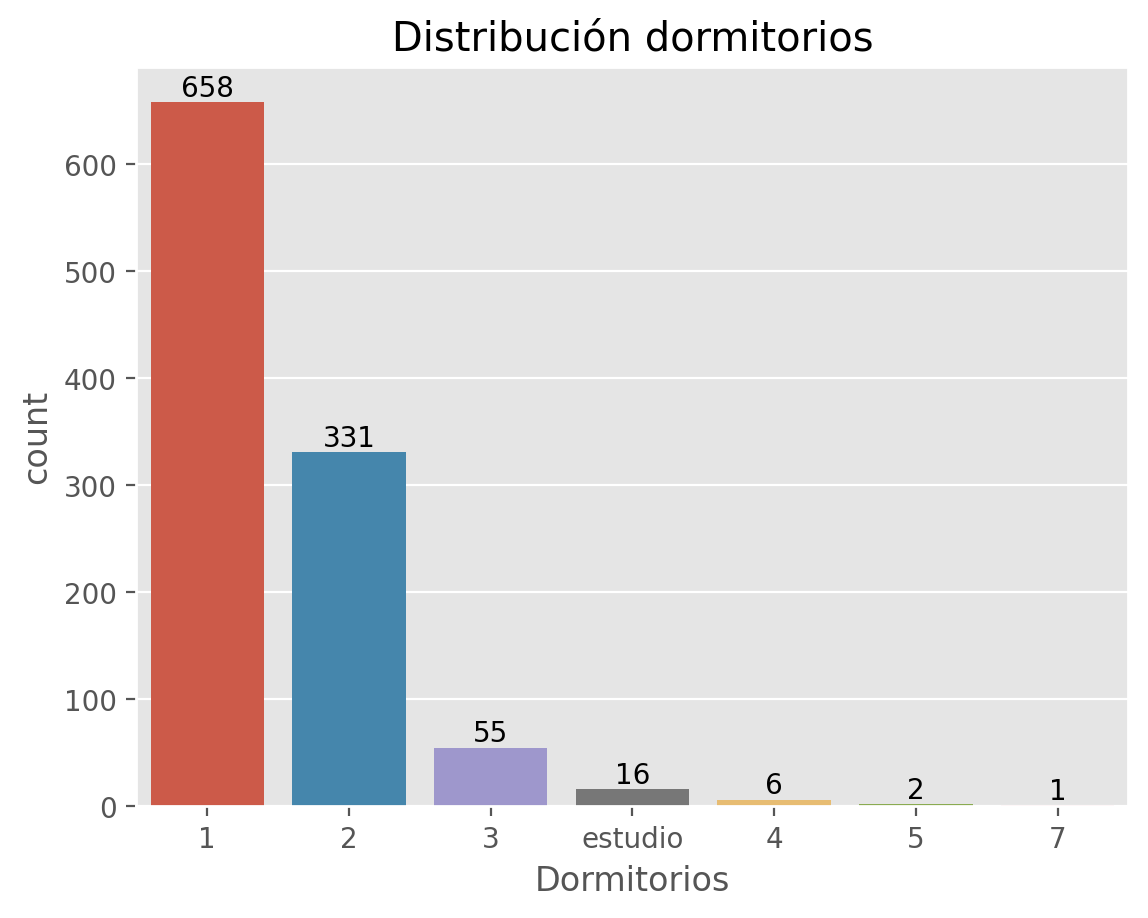

In [8]:
ax = sns.countplot(data=data_procesada,x='Dormitorios',order=data_procesada["Dormitorios"].value_counts().index)

# Agregar los valores encima de las barras
for bar in ax.containers:
    ax.bar_label(bar, fmt='%d')  # Agrega etiquetas con formato entero
plt.title('Distribución dormitorios')
plt.show()

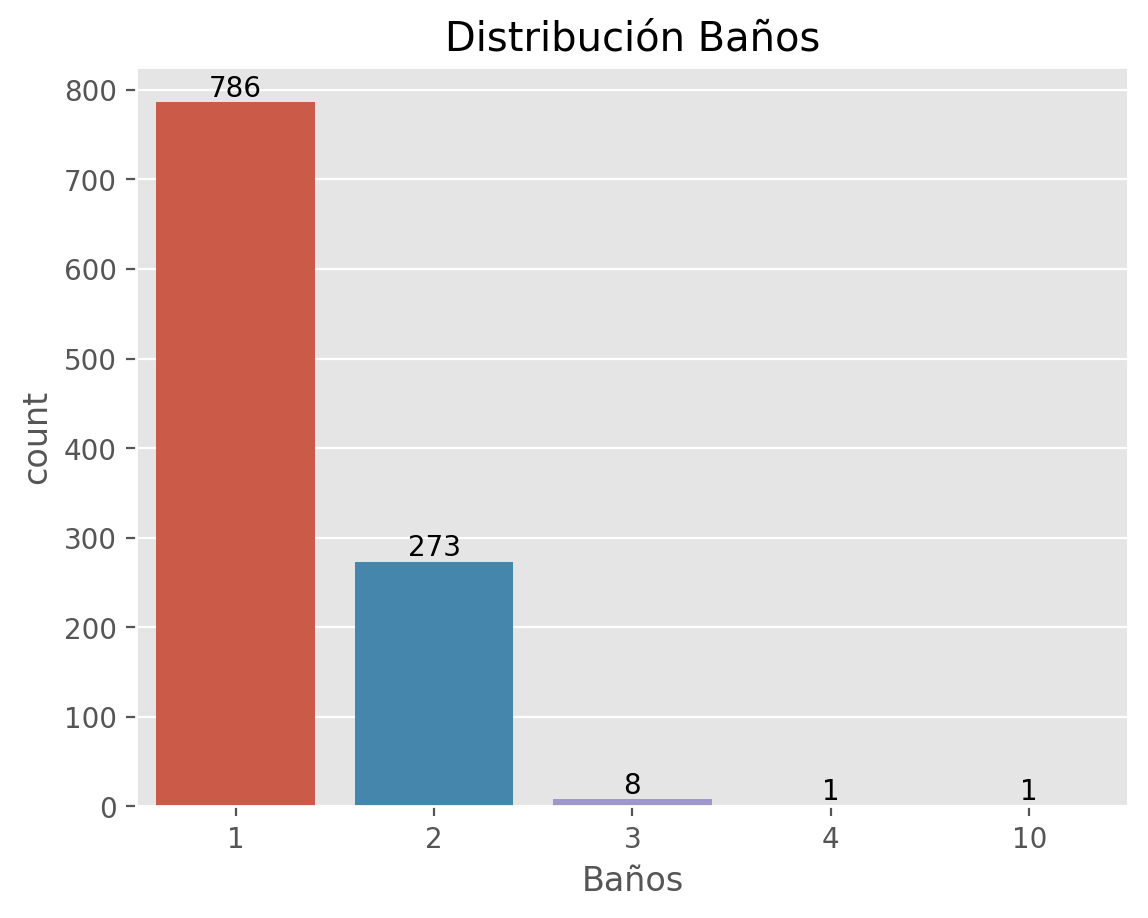

In [9]:
ax = sns.countplot(data=data_procesada,x='Baños',order=data_procesada["Baños"].value_counts().index)

# Agregar los valores encima de las barras
for bar in ax.containers:
    ax.bar_label(bar, fmt='%d')  # Agrega etiquetas con formato entero
plt.title('Distribución Baños')
plt.show()

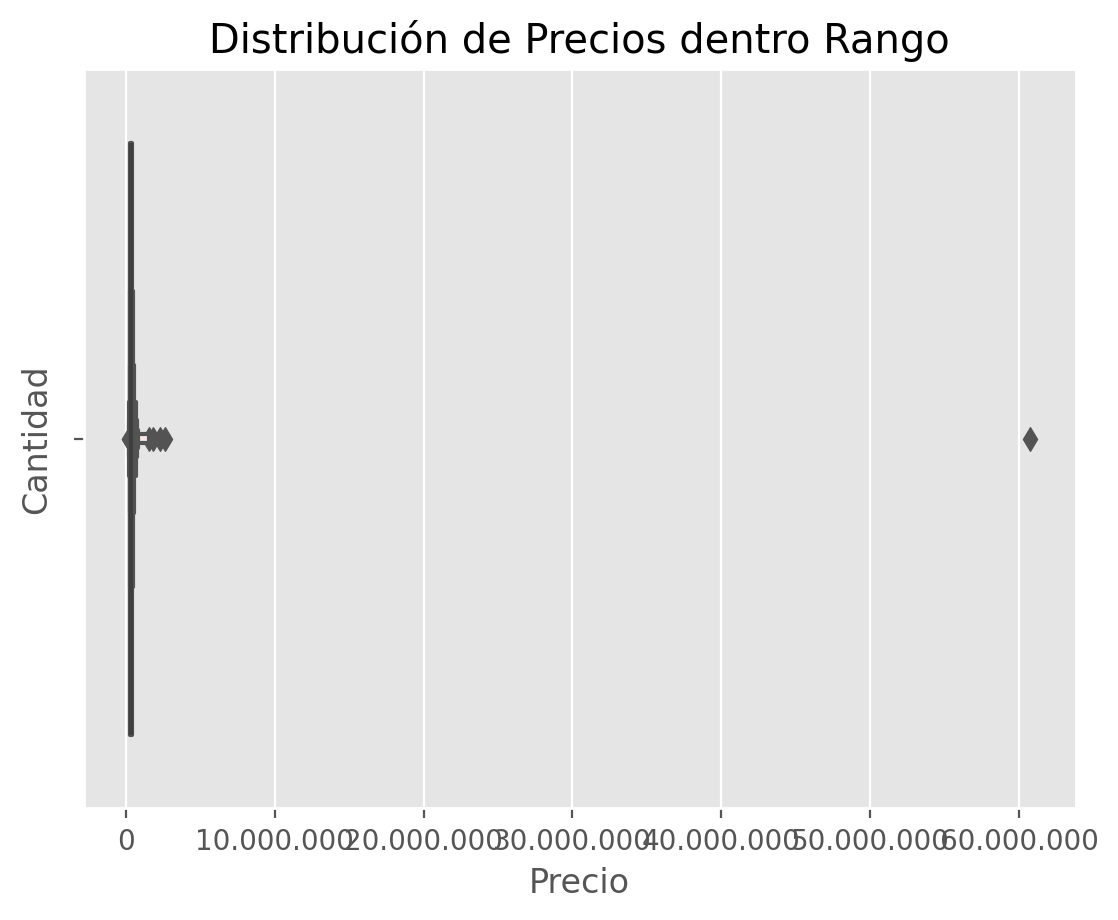

In [10]:
# Histograma: Precio
plt.ticklabel_format(style='plain', axis='x')
sns.boxenplot(data=data_procesada, x='Precio_Numerico')
plt.title('Distribución de Precios dentro Rango')
plt.xlabel("Precio")
plt.ylabel("Cantidad")
plt.gca().xaxis.set_major_formatter(FuncFormatter(format_miles))
plt.show()

In [11]:
# Ordenar los valores de la columna 'Precio_Numerico' en orden ascendente
data_ordenada = data_procesada.sort_values(by='Precio_Numerico', ascending=False)

# Mostrar el DataFrame ordenado
data_ordenada.head(20)

,Nombre Propiedad,Precio,Dormitorios,Baños,Metros Cuadrados,Dirección,Moneda,Precio_Numerico
989,Se Vende Hermoso Dpto. En Pleno Centro De San...,UF1.590,1,1,45.00000,"Bandera, Centro Histórico De Santi...",UF,60772980
573,Arriendo De Departamento 1 Dormitorio Santiago...,$2.650.000,1,1,29.00000,"Tucapel Jiménez, 136, Centro Histó...",CLP,2650000
48,Precioso Departamento Parque Forestal/ Bellas ...,UF60,4,4,140.00000,"Ismael Valdés Vergara 400, Centro ...",UF,2293320
244,Vista Panorámica Al Cerro San Cristóbal (54970),UF47,3,2,155.00000,Vista Panorámica Al Museo De Bella...,UF,1796434
39,Oficina 7 Privados,UF40,7,2,200.00000,"José Miguel De La Barra 508, Centr...",UF,1528880
43,Agustinas / Amunategui / Manuel Rodriguez,$1.500.000,3,3,110.00000,"Elías Fernández Albano, Centro His...",CLP,1500000
293,"Barrio Lastarria, Parque Forestal, Departament...",$900.000,3,2,110.00000,"José Miguel De La Barra 536, Santi...",CLP,900000
655,¡vive En El Corazón Vibrante De Santiago!,$890.000,3,2,148.00000,"Jose Miguel De La Barra 450, Depto...",CLP,890000
272,Dpto. Remodelado A 6 Min. Metro Bellas Artes (...,$850.000,2,3,90.00000,Dpto. Remodelado A Pasos Parque Fo...,CLP,850000
559,Departamento Remodelado En Arriendo-2 Dormitor...,$850.000,2,3,112.00000,"Bellas Artes - Lastarria, Centro H...",CLP,850000


In [12]:
display(data_ordenada)

,Nombre Propiedad,Precio,Dormitorios,Baños,Metros Cuadrados,Dirección,Moneda,Precio_Numerico
989,Se Vende Hermoso Dpto. En Pleno Centro De San...,UF1.590,1,1,45.00000,"Bandera, Centro Histórico De Santi...",UF,60772980
573,Arriendo De Departamento 1 Dormitorio Santiago...,$2.650.000,1,1,29.00000,"Tucapel Jiménez, 136, Centro Histó...",CLP,2650000
48,Precioso Departamento Parque Forestal/ Bellas ...,UF60,4,4,140.00000,"Ismael Valdés Vergara 400, Centro ...",UF,2293320
244,Vista Panorámica Al Cerro San Cristóbal (54970),UF47,3,2,155.00000,Vista Panorámica Al Museo De Bella...,UF,1796434
39,Oficina 7 Privados,UF40,7,2,200.00000,"José Miguel De La Barra 508, Centr...",UF,1528880
...,...,...,...,...,...,...,...,...
843,Bombero Ossa / Ahumada,$200.000,1,1,20.00000,"Bombero Adolfo Ossa 900 - 1200, Ce...",CLP,200000
792,En Arriendo Departamento Calle Compañía - Metr...,$200.000,1,1,35.00000,"Compañía De Jesús 1200 - 1500, Cen...",CLP,200000
725,Calle San Pablo 1295 Metro Plaza De Armas 1d+1b,$200.000,1,1,30.00000,Calle San Pablo 1295 Metro Plaza ...,CLP,200000
58,NaN,UF5,1,1,20.00000,"Depto 1d + 1b Muy Buena Ubicacion,...",UF,191110


In [13]:
# Ordenar los valores de la columna 'Precio_Numerico' en orden ascendente
data_ordenada_des = data_procesada.sort_values(by='Precio_Numerico', ascending=True)

# Mostrar el DataFrame ordenado
data_ordenada_des.head(50)

,Nombre Propiedad,Precio,Dormitorios,Baños,Metros Cuadrados,Dirección,Moneda,Precio_Numerico
9,Departamento Máximo Humbser Id: 92334,$189.000,1,1,21.00000,"Máximo Humbser, Centro Histórico D...",CLP,189000
58,NaN,UF5,1,1,20.00000,"Depto 1d + 1b Muy Buena Ubicacion,...",UF,191110
725,Calle San Pablo 1295 Metro Plaza De Armas 1d+1b,$200.000,1,1,30.00000,Calle San Pablo 1295 Metro Plaza ...,CLP,200000
843,Bombero Ossa / Ahumada,$200.000,1,1,20.00000,"Bombero Adolfo Ossa 900 - 1200, Ce...",CLP,200000
839,Oportunidad Estudio Metro Bellas Artes,$200.000,1,1,30.00000,"Ismael Valdés Vergara 492, Santiag...",CLP,200000
794,En Arriendo Departamento Calle Teatinos- Metro...,$200.000,1,1,33.00000,"Teatinos 600 - 900, Centro Históri...",CLP,200000
792,En Arriendo Departamento Calle Compañía - Metr...,$200.000,1,1,35.00000,"Compañía De Jesús 1200 - 1500, Cen...",CLP,200000
1068,NaN,$220.000,1,1,32.00000,San Martin Con San Pablo / Santiag...,CLP,220000
864,Departamento Estudio En Arriendo En Santiago C...,$220.000,1,1,18.00000,"Esquina Amunategui, Centro Históri...",CLP,220000
846,Arriendo Depto1 Ambiente Luminoso Lindo Y Mode...,$220.000,1,1,30.00000,"Amunategui, Centro Histórico De Sa...",CLP,220000


In [14]:
data_procesada = data_procesada.loc[(data_procesada['Precio_Numerico'] <= 8000000) & (data_procesada['Metros Cuadrados']>=20)]

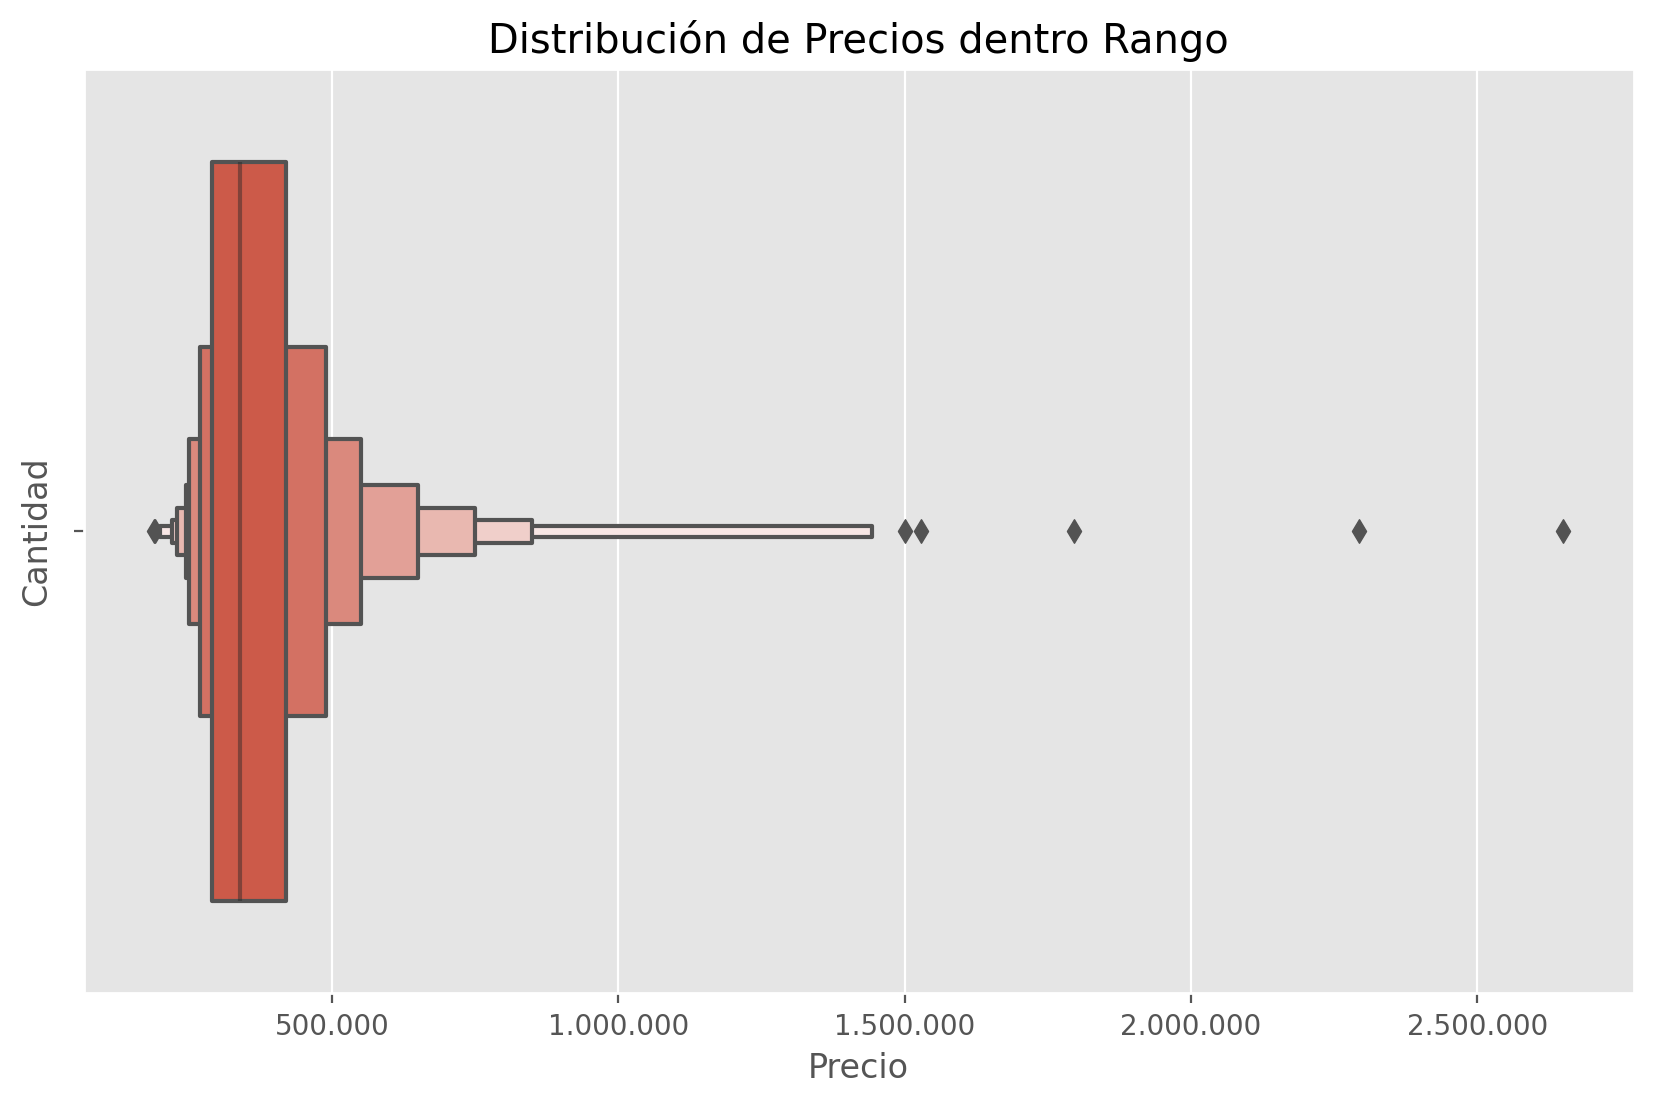

In [15]:
# Histograma: Precio
plt.figure(figsize=(10,6))
plt.ticklabel_format(style='plain', axis='x')
sns.boxenplot(data=data_procesada, x='Precio_Numerico')
plt.title('Distribución de Precios dentro Rango')
plt.xlabel("Precio")
plt.ylabel("Cantidad")
plt.gca().xaxis.set_major_formatter(FuncFormatter(format_miles))
plt.show()

----

In [16]:
#procedemos a analizar la inforamcion por los rangos de precio

# Crear los rangos y etiquetas
bins = list(range(0, 1000000, 100000))  
labels = [f'{bins[i]}-{bins[i+1]}' for i in range(len(bins) - 1)]  # Etiquetas de los rangos

# Clasificar los precios y contar sin modificar el DataFrame
conteo_rangos = pd.cut(data_procesada['Precio_Numerico'], bins=bins, labels=labels, right=False).value_counts().sort_index()

# Mostrar el conteo
print(conteo_rangos)

0-100000           0
100000-200000      2
200000-300000    291
300000-400000    438
400000-500000    197
500000-600000     71
600000-700000     27
700000-800000     11
800000-900000      6
Name: Precio_Numerico, dtype: int64


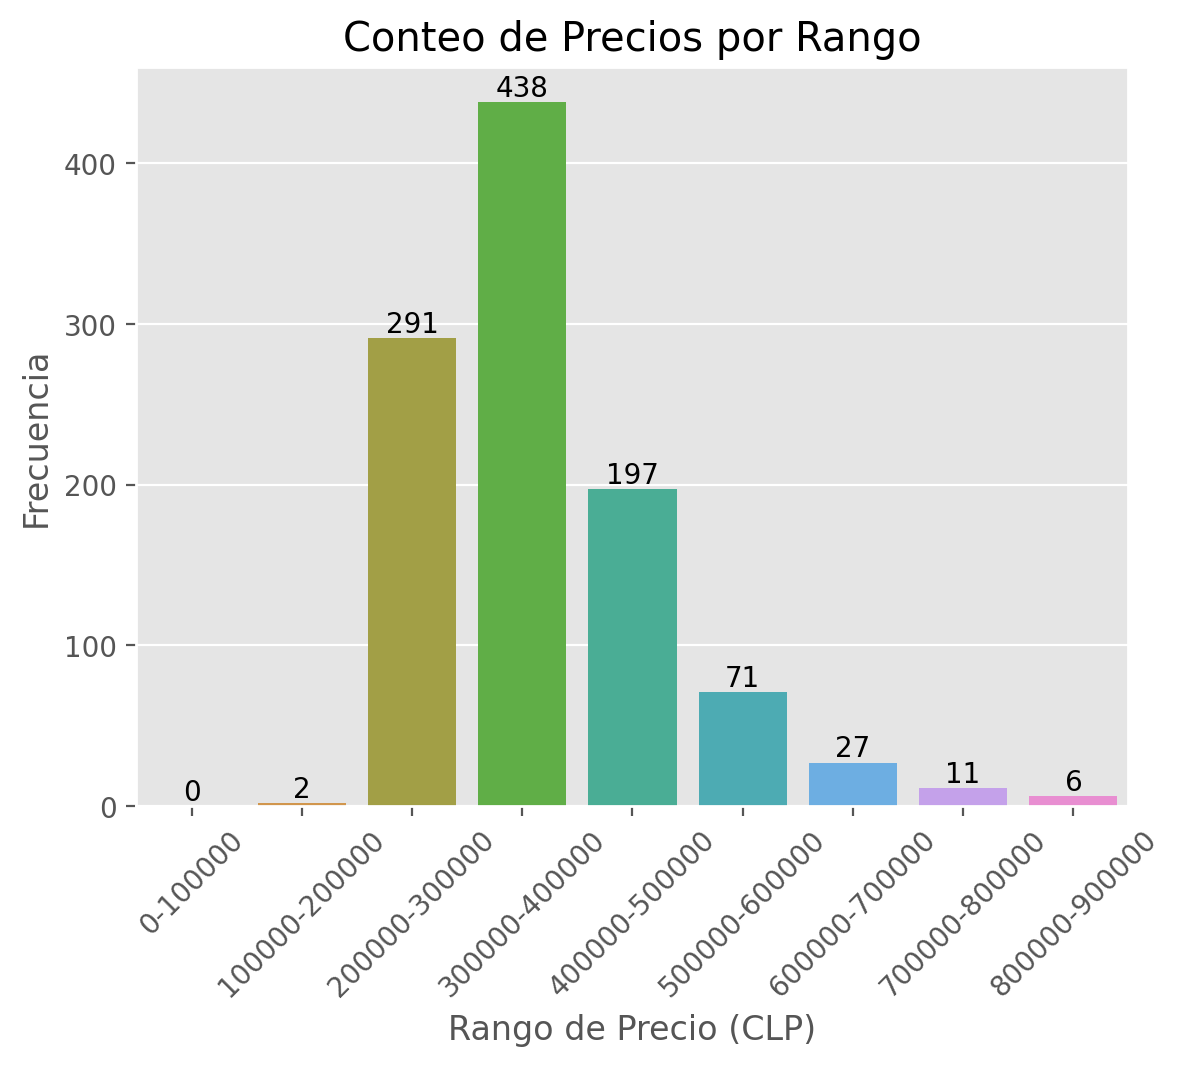

In [17]:
ax = sns.barplot(x=conteo_rangos.index, y=conteo_rangos.values)

for bar in ax.containers:
    ax.bar_label(bar, fmt='%d')  # Agrega etiquetas con formato entero
plt.title('Conteo de Precios por Rango')
plt.xlabel('Rango de Precio (CLP)')
plt.ylabel('Frecuencia')
plt.xticks(rotation=45)  # Rotar etiquetas para mejor lectura
plt.show()

In [18]:
data_filtrada_precios = data_procesada.loc[data_procesada['Precio_Numerico'] <= 1000000]

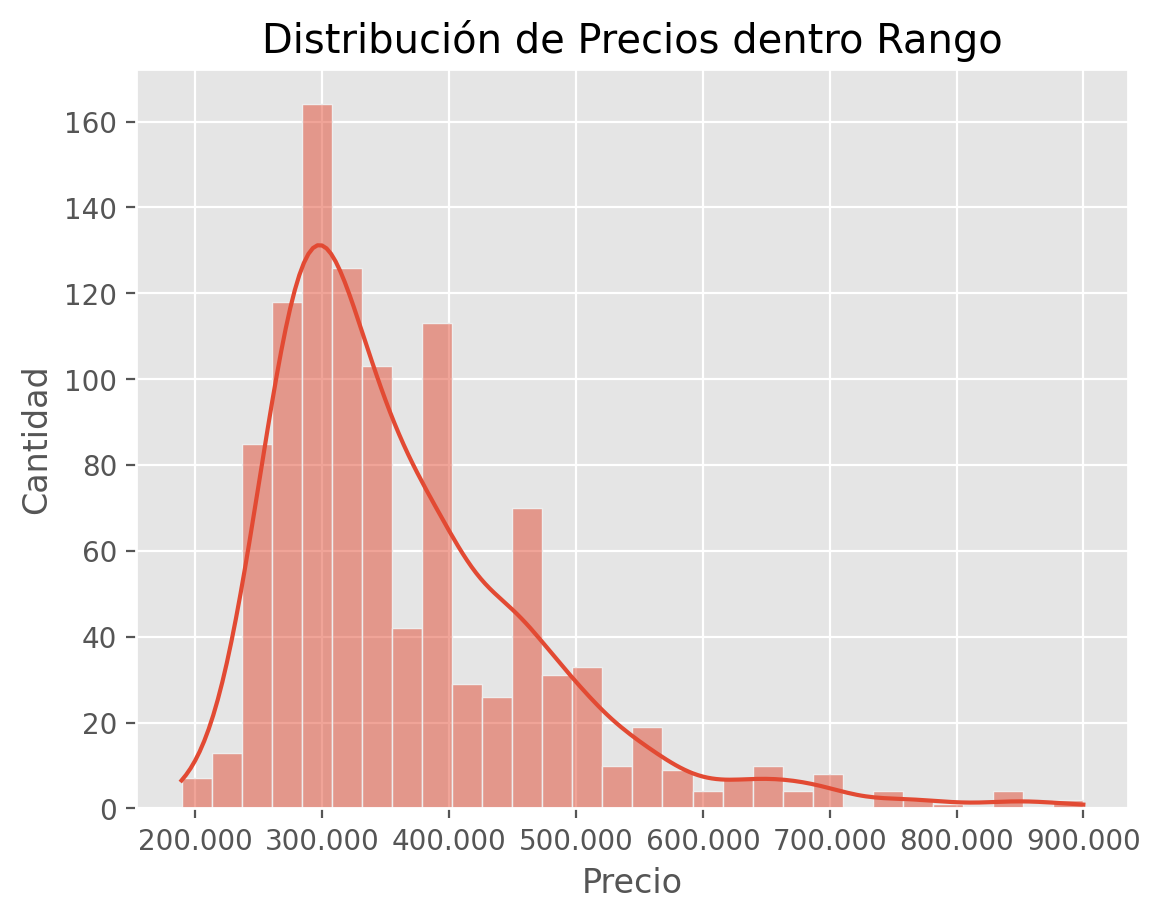

In [19]:
# Histograma: Precio
plt.ticklabel_format(style='plain', axis='x')
sns.histplot(data=data_filtrada_precios, x='Precio_Numerico', bins=30, kde=True)
plt.title('Distribución de Precios dentro Rango')
plt.xlabel("Precio")
plt.ylabel("Cantidad")
plt.gca().xaxis.set_major_formatter(FuncFormatter(format_miles))
plt.show()

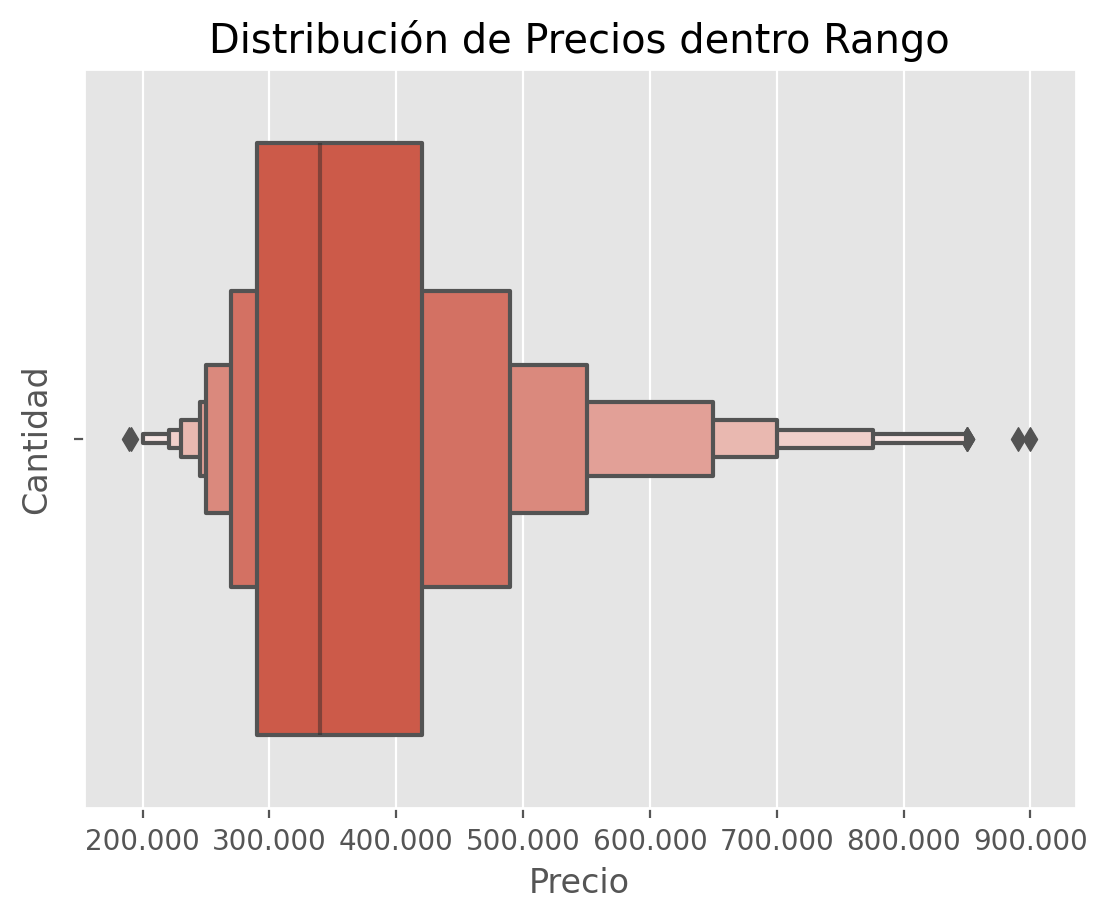

In [20]:
# Histograma: Precio
plt.ticklabel_format(style='plain', axis='x')
sns.boxenplot(data=data_filtrada_precios, x='Precio_Numerico')
plt.title('Distribución de Precios dentro Rango')
plt.xlabel("Precio")
plt.ylabel("Cantidad")
plt.gca().xaxis.set_major_formatter(FuncFormatter(format_miles))
plt.show()

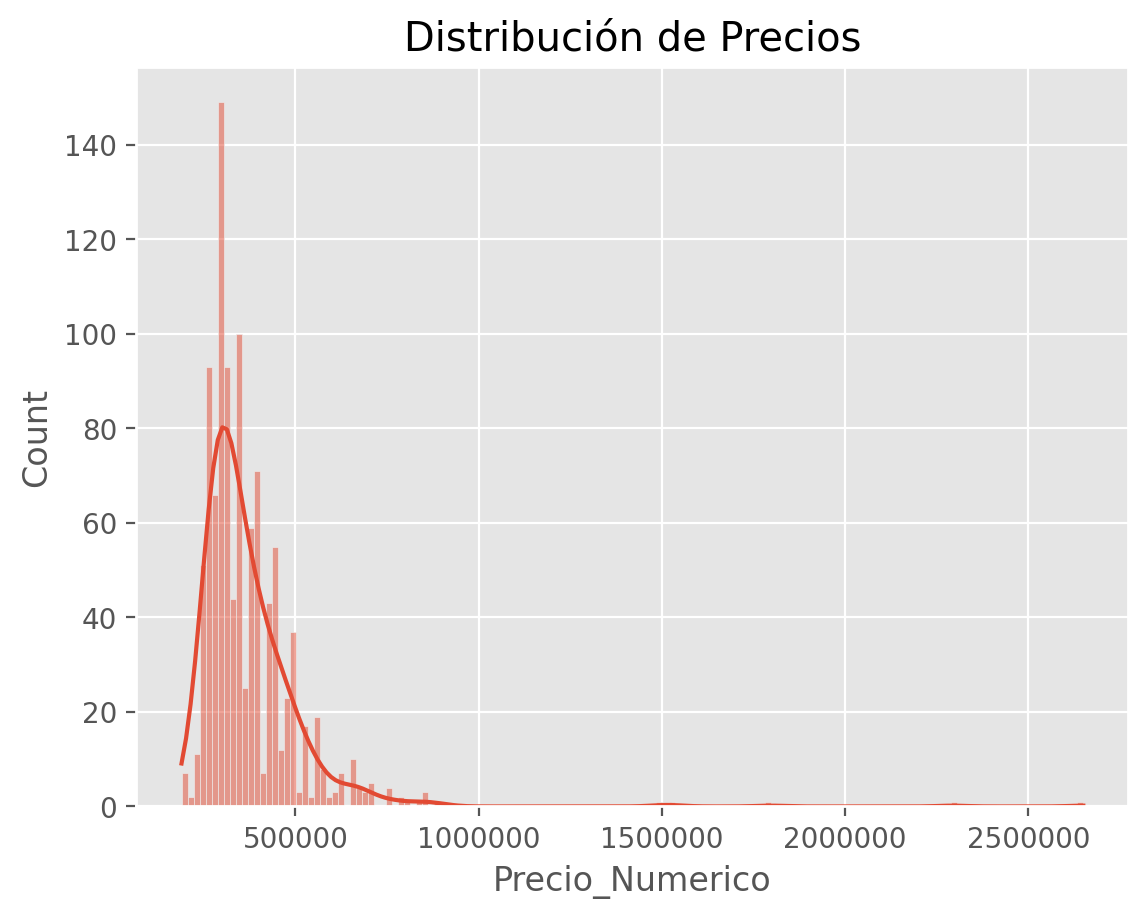

In [21]:
# Histograma: Precio_Numerico
plt.ticklabel_format(style='plain', axis='x')
sns.histplot(data=data_procesada, x='Precio_Numerico', bins=150, kde=True)
plt.title('Distribución de Precios')
plt.show()

----

Text(0.5, 1.0, 'Distribución de Precios')

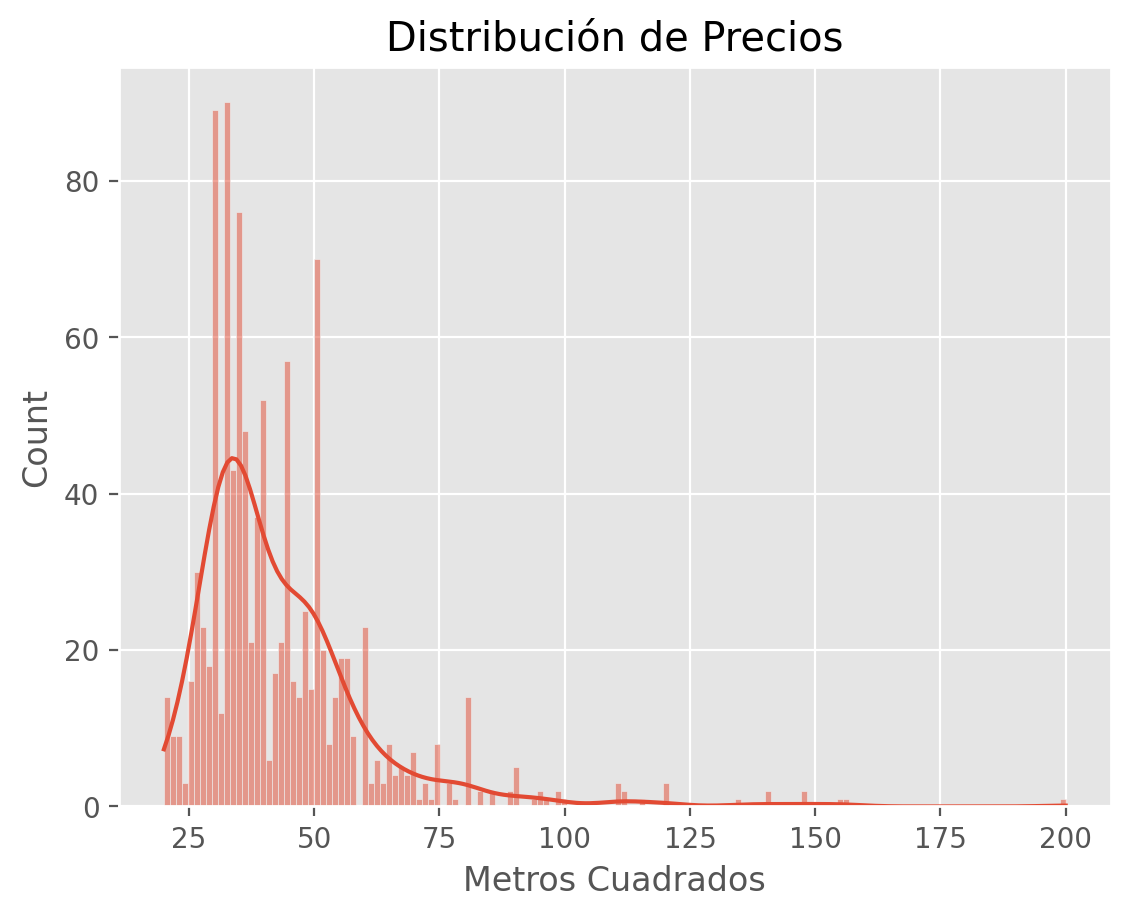

In [22]:
# Histograma: Metros cuadrados
plt.ticklabel_format(style='plain', axis='x')
sns.histplot(data=data_procesada, x='Metros Cuadrados', bins=150, kde=True)
plt.title('Distribución de Precios')

In [23]:
#procedemos a analizar la inforamcion por los rangos de precio

# Crear los rangos y etiquetas
bins_metros = list(range(0, 500, 25))  # Rangos de 0 a 6M con incrementos de 1M
labels_metros = [f'{bins_metros[i]}-{bins_metros[i+1]}' for i in range(len(bins_metros) - 1)]  # Etiquetas de los rangos

# Clasificar los precios y contar sin modificar el DataFrame
conteo_rangos_metros = pd.cut(data_procesada['Metros Cuadrados'], bins=bins_metros, labels=labels_metros, right=False).value_counts().sort_index()

# Mostrar el conteo
print(conteo_rangos_metros)

0-25        35
25-50      726
50-75      229
75-100      41
100-125     10
125-150      5
150-175      2
175-200      0
200-225      1
225-250      0
250-275      0
275-300      0
300-325      0
325-350      0
350-375      0
375-400      0
400-425      0
425-450      0
450-475      0
Name: Metros Cuadrados, dtype: int64


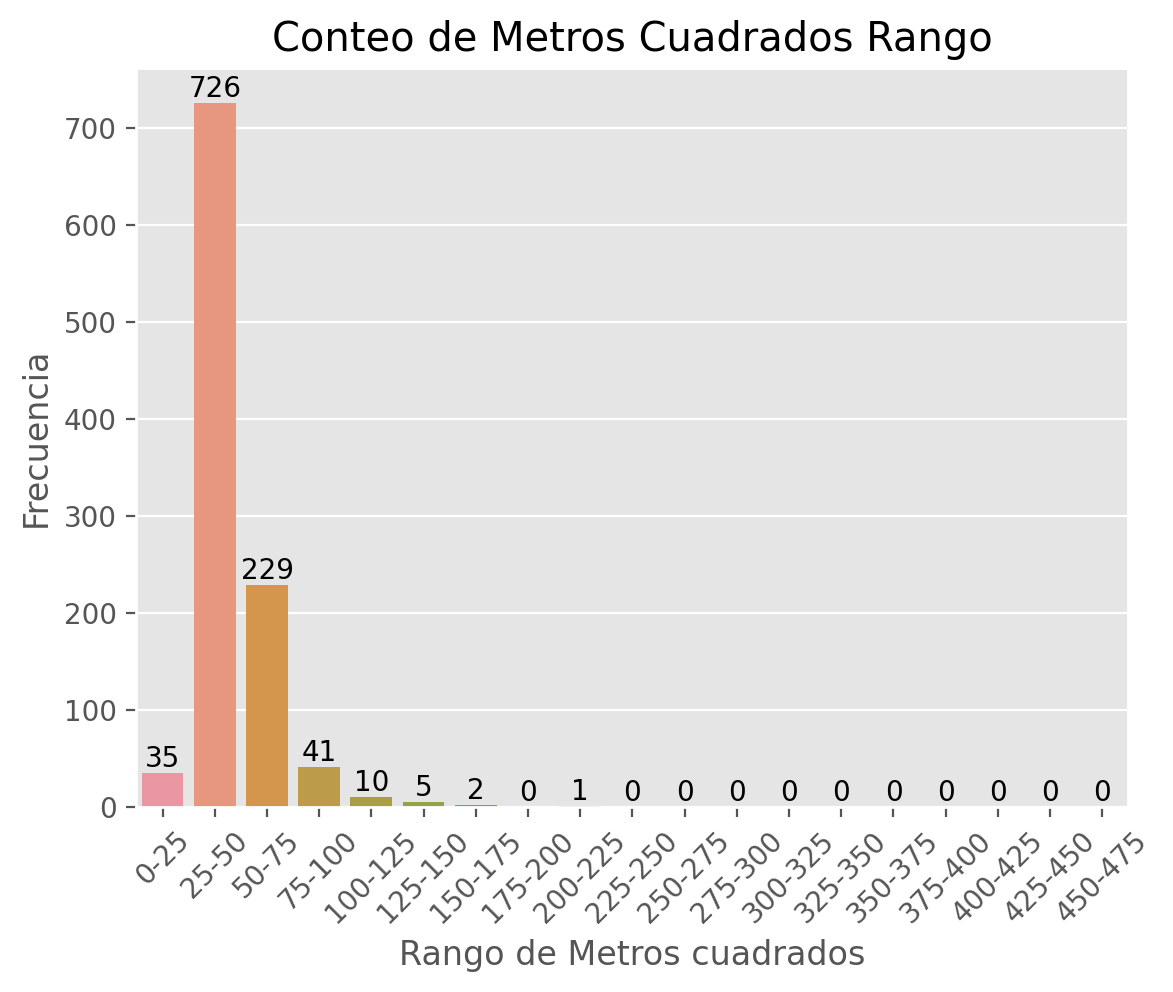

In [24]:
ax = sns.barplot(x=conteo_rangos_metros.index, y=conteo_rangos_metros.values)

for bar in ax.containers:
    ax.bar_label(bar, fmt='%d')  # Agrega etiquetas con formato entero
plt.title('Conteo de Metros Cuadrados Rango')
plt.xlabel('Rango de Metros cuadrados')
plt.ylabel('Frecuencia')
plt.xticks(rotation=45)  # Rotar etiquetas para mejor lectura
plt.show()

In [25]:
data_filtrada_metros = data_procesada.loc[data_procesada["Metros Cuadrados"] <= 100]

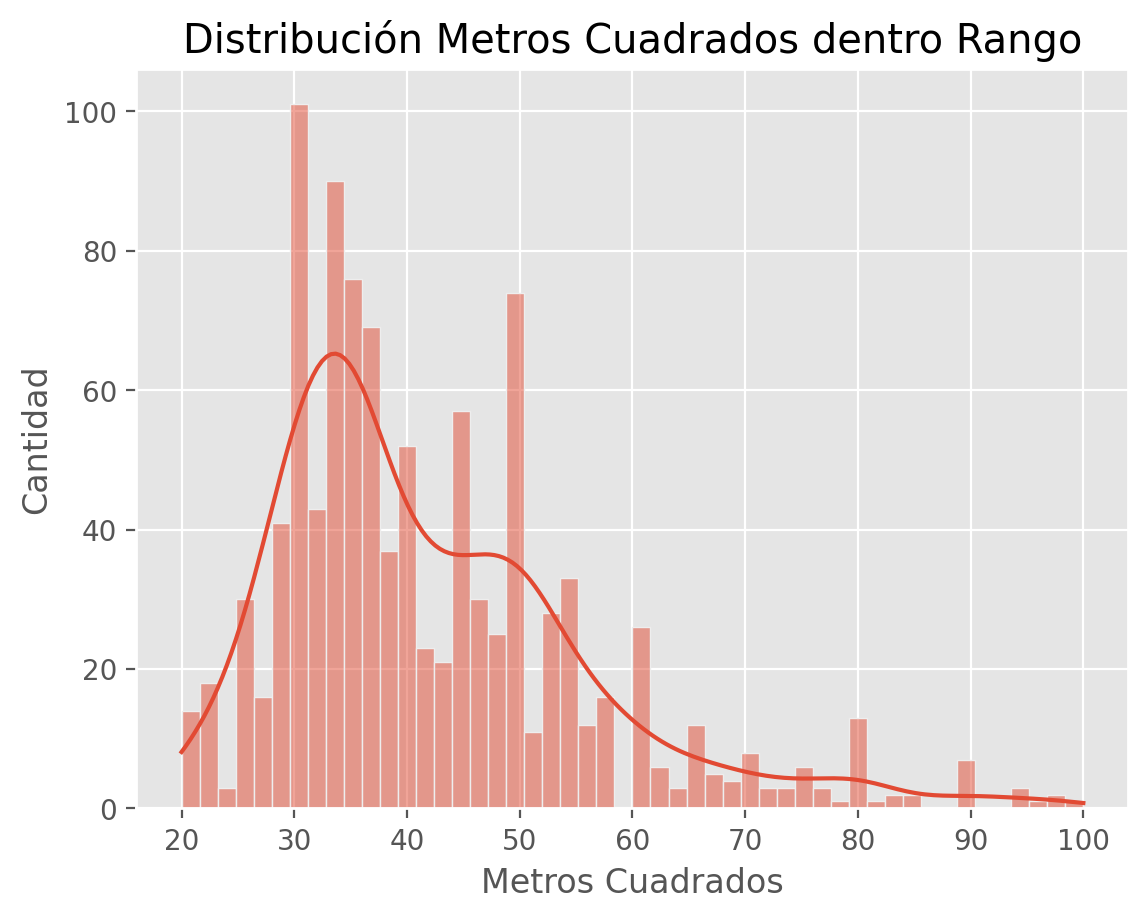

In [26]:
# Histograma: M2
plt.ticklabel_format(style='plain', axis='x')
sns.histplot(data=data_filtrada_metros, x='Metros Cuadrados', bins=50, kde=True)
plt.title('Distribución Metros Cuadrados dentro Rango')
plt.xlabel("Metros Cuadrados")
plt.ylabel("Cantidad")
plt.gca().xaxis.set_major_formatter(FuncFormatter(format_miles))
plt.show()

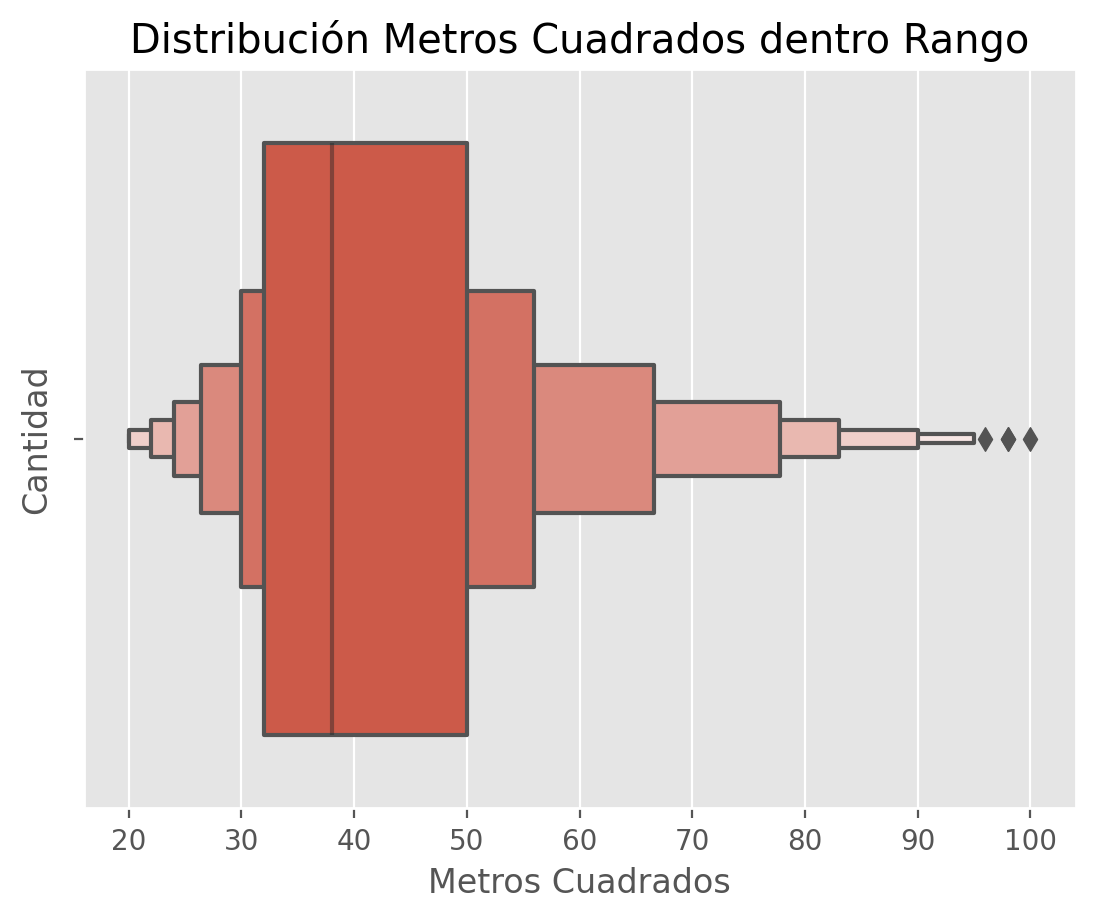

In [27]:
# Boxplot: m2 rangos
plt.ticklabel_format(style='plain', axis='x')
sns.boxenplot(data=data_filtrada_metros, x='Metros Cuadrados')
plt.title('Distribución Metros Cuadrados dentro Rango')
plt.xlabel("Metros Cuadrados")
plt.ylabel("Cantidad")
plt.gca().xaxis.set_major_formatter(FuncFormatter(format_miles))
plt.show()

In [28]:
display(data_procesada.loc[data_procesada["Metros Cuadrados"] < 20])

,Nombre Propiedad,Precio,Dormitorios,Baños,Metros Cuadrados,Dirección,Moneda,Precio_Numerico


----

In [29]:
#caluclamos los precios promedios de los departmantos para todos, los que valen hasta 1M y Metros cuaadrados de menos de 100

# Calcular los promedios
promedio_precios_filtrados = data_filtrada_precios['Precio_Numerico'].mean()
promedio_metros_filtrados = data_filtrada_metros['Precio_Numerico'].mean()
promedio_general_precios = data_procesada['Precio_Numerico'].mean()


In [30]:
print(promedio_general_precios)

373586.7521448999


In [31]:
comparativa = pd.DataFrame({
    "Categoría": ["Precios <= 1.000.000", "Metros <= 100", "Promedio General"],
    "Promedio Precio": [promedio_precios_filtrados, promedio_metros_filtrados, promedio_general_precios]
})

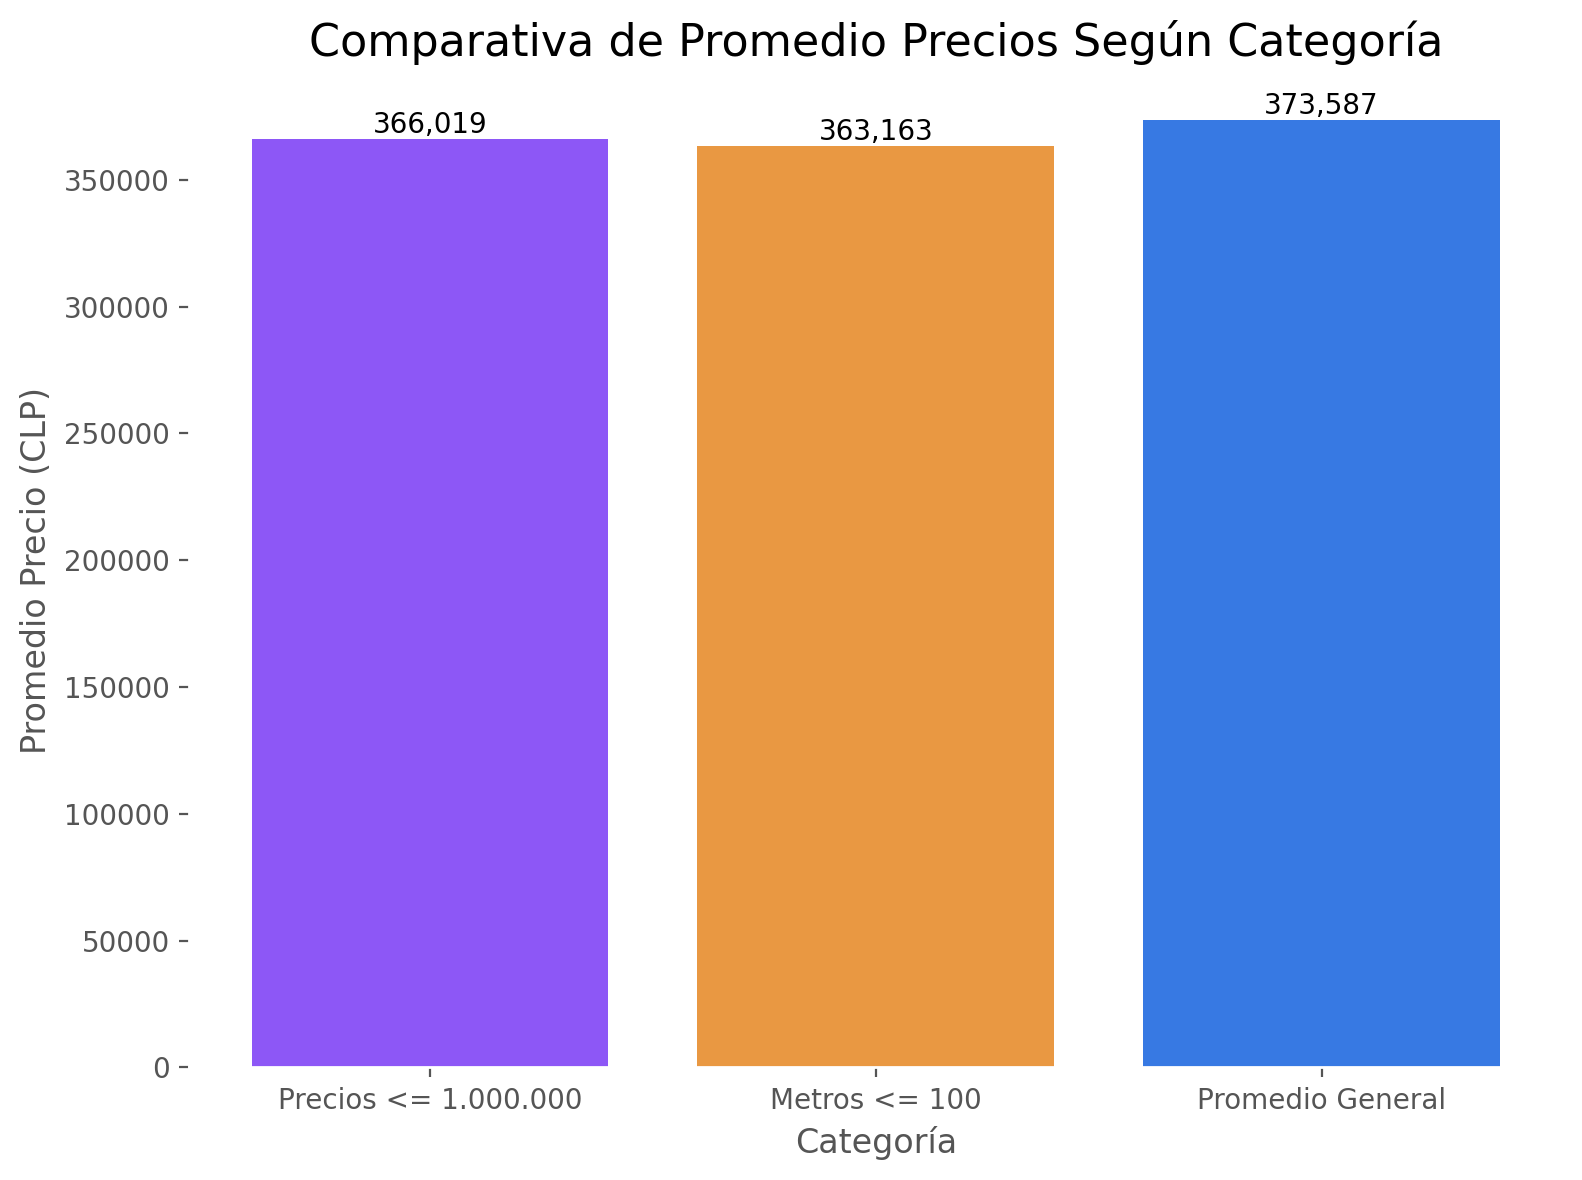

In [32]:
# Crear el gráfico de barras con colores personalizados
plt.figure(figsize=(8, 6))
colors = ["#8D57F6", "#E99842", "#3779E3"]
bars = plt.bar(comparativa["Categoría"], comparativa["Promedio Precio"], color=colors)

# Añadir valores promedio encima de las barras
for bar in bars:
    plt.text(
        bar.get_x() + bar.get_width() / 2,  # Posición x
        bar.get_height(),  # Altura (valor del promedio)
        f"{bar.get_height():,.0f}",  # Texto del valor formateado
        ha="center", va="bottom", fontsize=10, color="black"
    )

# Añadir títulos y etiquetas
plt.ticklabel_format(style='plain', axis='y')
plt.title("Comparativa de Promedio Precios Según Categoría", fontsize=16)
plt.xlabel("Categoría", fontsize=12)
plt.ylabel("Promedio Precio (CLP)", fontsize=12)
plt.xticks(fontsize=10)

# Mostrar el gráfico
plt.gca().set_facecolor('white') 
plt.grid(True, linestyle='--', color='white', alpha=0.7)
plt.tight_layout()
plt.show()

----

/var/folders/tg/h6x1ph8j2dbgdffzjyvt5s8r0000gn/T/ipykernel_60151/3508271425.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_procesada['Precio por Metro Cuadrado'] = data_procesada['Precio_Numerico'] / data_procesada['Metros Cuadrados']


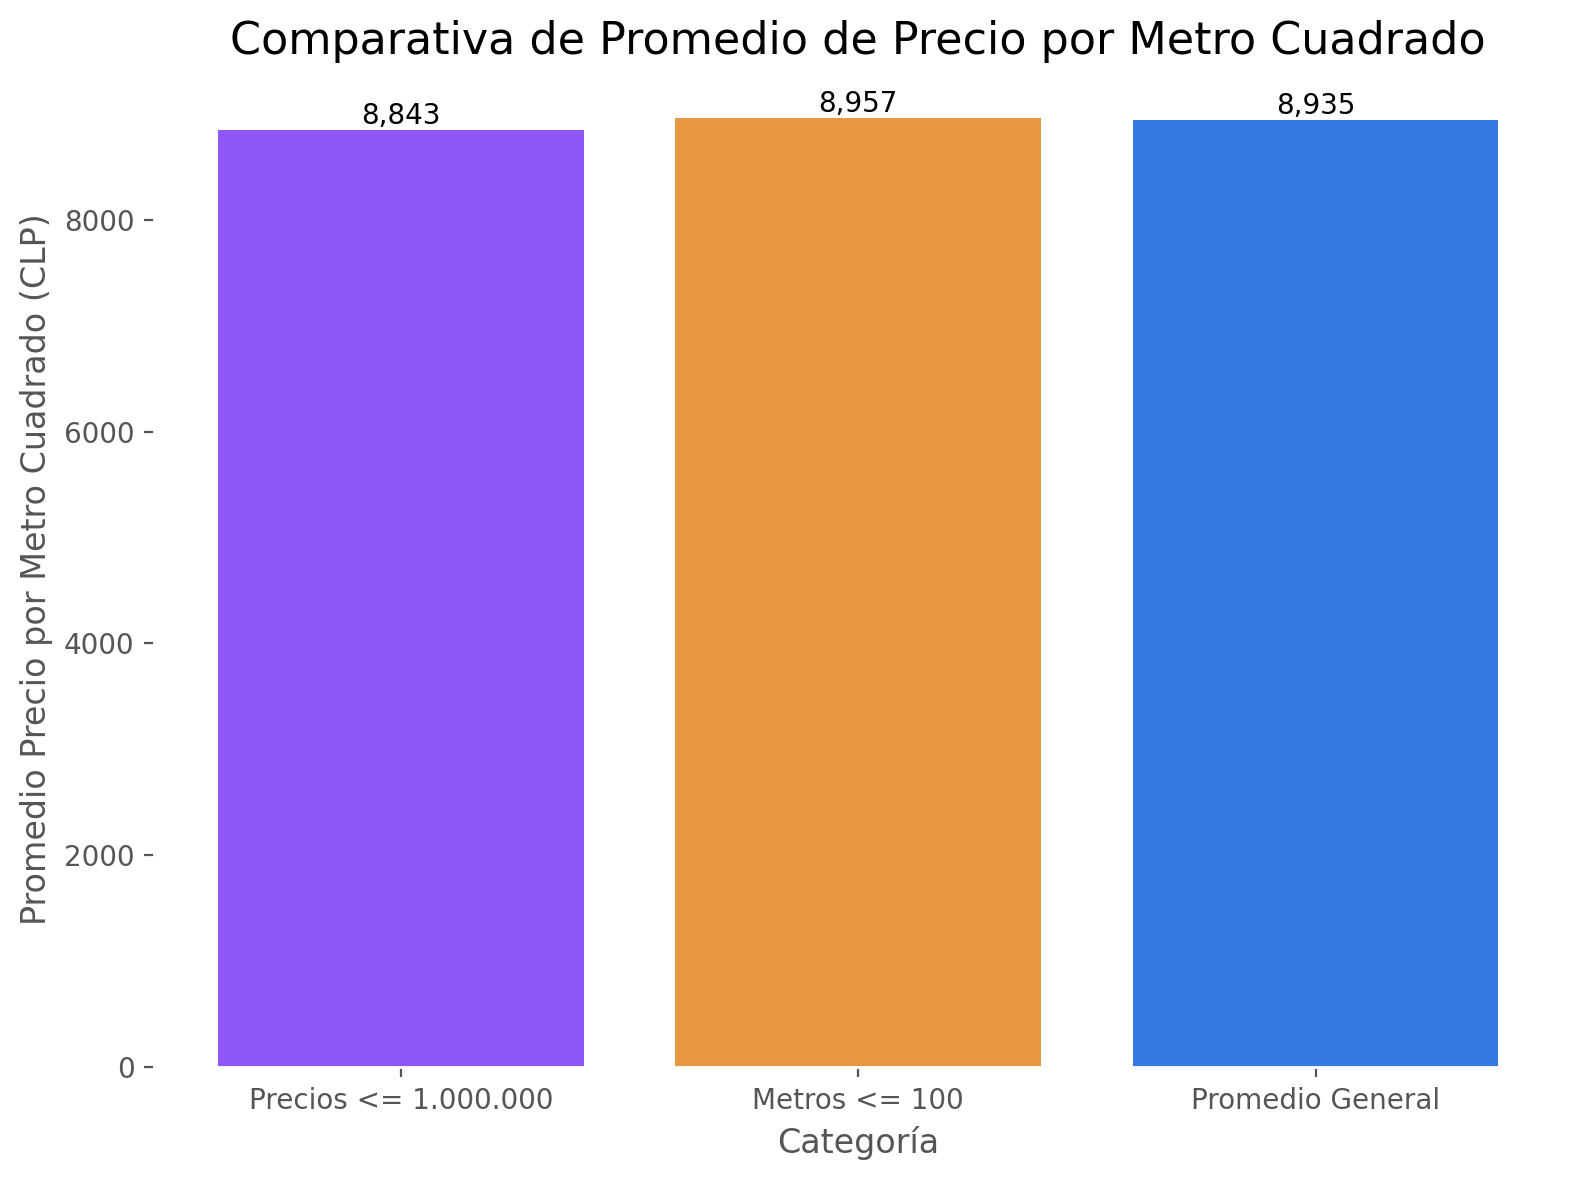

              Categoría  Promedio Precio por Metro Cuadrado
0  Precios <= 1.000.000                          8843.01578
1         Metros <= 100                          8956.79686
2      Promedio General                          8934.92784


In [33]:
#procedemos a ver el el precio promeido por metro cuadraro
import matplotlib.pyplot as plt

# Calcular el precio por metro cuadrado
data_procesada['Precio por Metro Cuadrado'] = data_procesada['Precio_Numerico'] / data_procesada['Metros Cuadrados']

# Filtrar datos según las condiciones
data_filtrada_precios = data_procesada.loc[data_procesada['Precio_Numerico'] <= 1000000]
data_filtrada_metros = data_procesada.loc[data_procesada["Metros Cuadrados"] <= 100]

# Calcular los promedios del precio por metro cuadrado
promedio_precio_metro_precios = data_filtrada_precios['Precio por Metro Cuadrado'].mean()
promedio_precio_metro_metros = data_filtrada_metros['Precio por Metro Cuadrado'].mean()
promedio_precio_metro_general = data_procesada['Precio por Metro Cuadrado'].mean()

# Crear un DataFrame comparativo con el precio por metro cuadrado
comparativa_metro = pd.DataFrame({
    "Categoría": ["Precios <= 1.000.000", "Metros <= 100", "Promedio General"],
    "Promedio Precio por Metro Cuadrado": [promedio_precio_metro_precios, promedio_precio_metro_metros, promedio_precio_metro_general]
})

# Crear el gráfico de barras con colores personalizados
plt.figure(figsize=(8, 6))
colors = ["#8D57F6", "#E99842", "#3779E3"]
bars = plt.bar(comparativa_metro["Categoría"], comparativa_metro["Promedio Precio por Metro Cuadrado"], color=colors)

# Añadir valores promedio encima de las barras
for bar in bars:
    plt.text(
        bar.get_x() + bar.get_width() / 2,  # Posición x
        bar.get_height(),  # Altura (valor del promedio)
        f"{bar.get_height():,.0f}",  # Texto del valor formateado
        ha="center", va="bottom", fontsize=10, color="black"
    )

# Añadir títulos y etiquetas
plt.ticklabel_format(style='plain', axis='y')
plt.title("Comparativa de Promedio de Precio por Metro Cuadrado", fontsize=16)
plt.xlabel("Categoría", fontsize=12)
plt.ylabel("Promedio Precio por Metro Cuadrado (CLP)", fontsize=12)
plt.xticks(fontsize=10)

# Mostrar el gráfico
plt.gca().set_facecolor('white') 
plt.grid(True, linestyle='--', color='white', alpha=0.7)
plt.tight_layout()
plt.show()

# Mostrar el DataFrame comparativo
print(comparativa_metro)

----

In [34]:
print(data_procesada['Dormitorios'].unique())


[1 2 'estudio' 3 7 4 5]


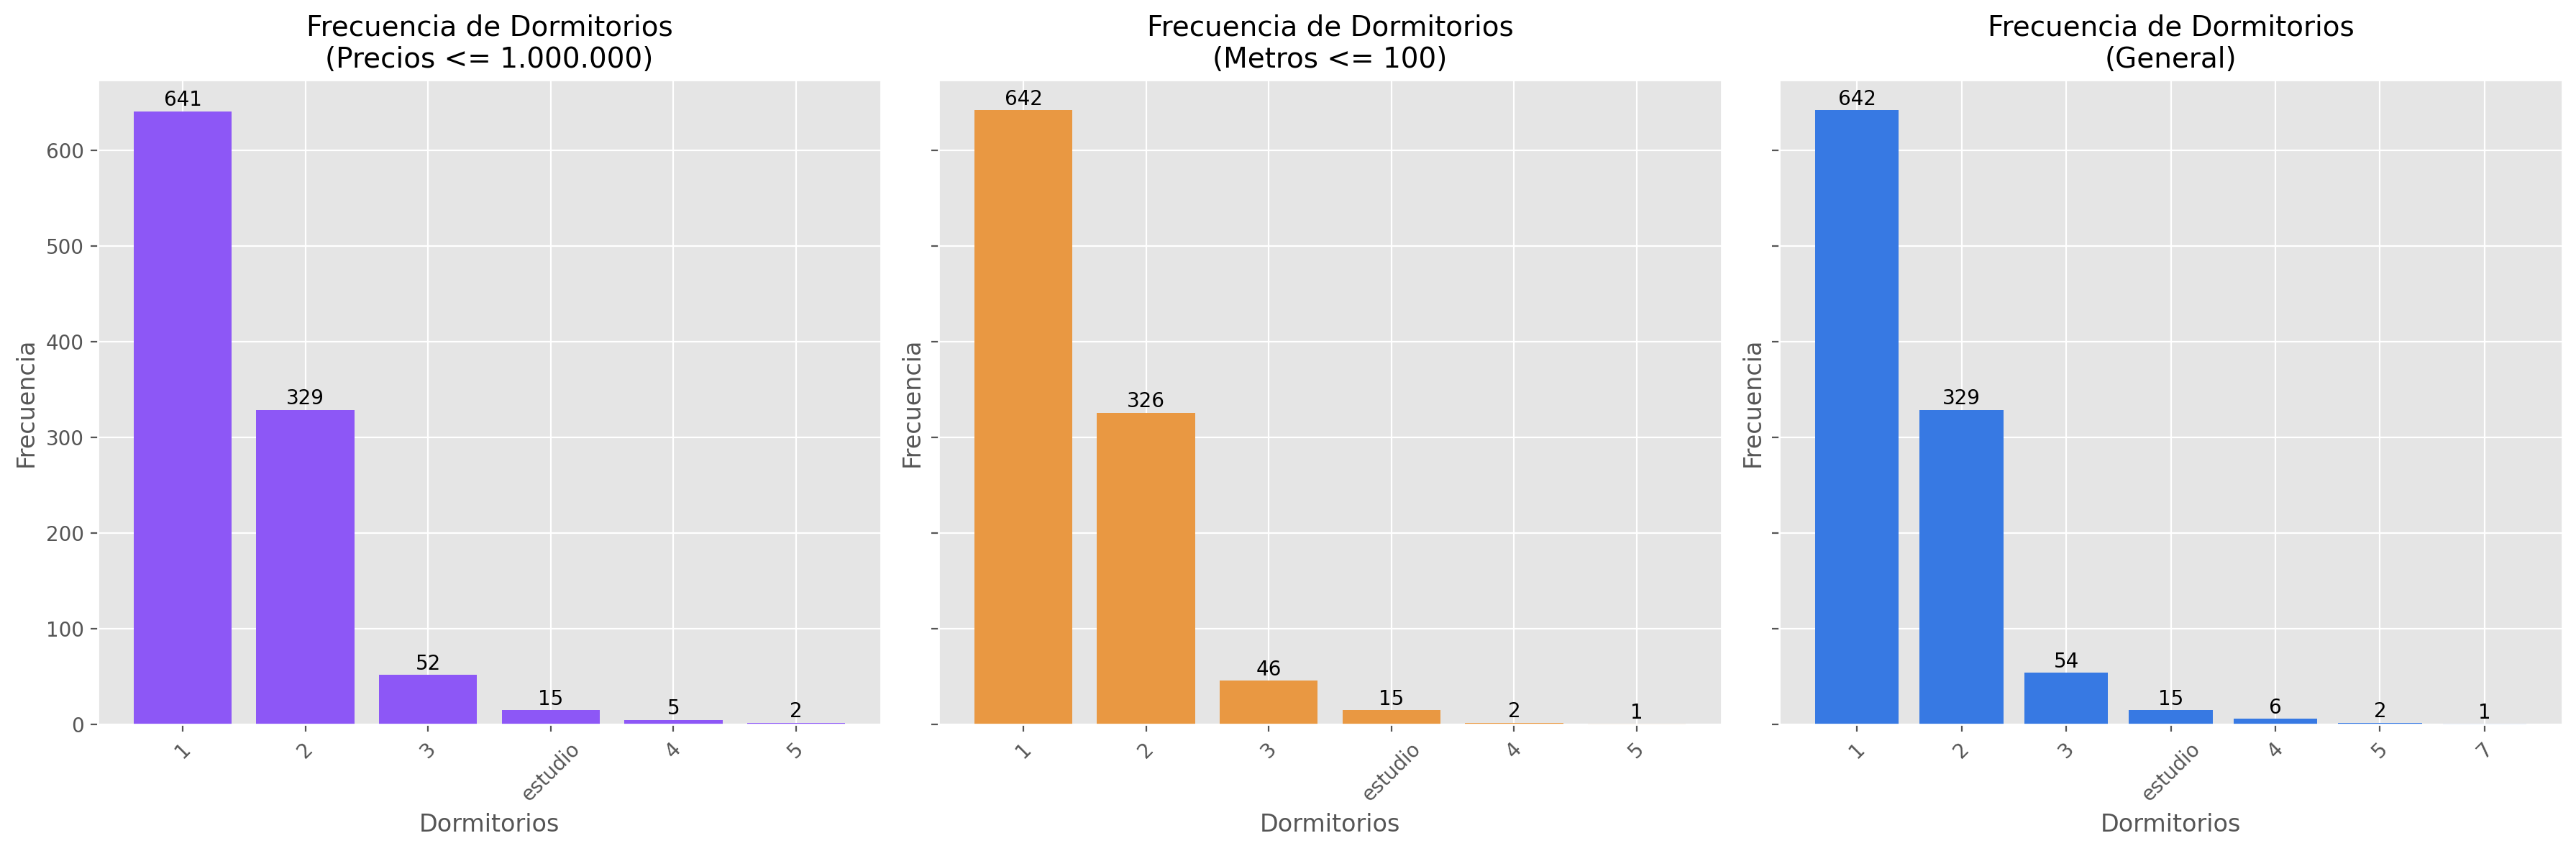

In [35]:
# Crear datasets para las categorías
dormitorios_precios = data_filtrada_precios['Dormitorios'].value_counts().reset_index()
dormitorios_metros = data_filtrada_metros['Dormitorios'].value_counts().reset_index()
dormitorios_general = data_procesada['Dormitorios'].value_counts().reset_index()  # Crear el dataset general

# Renombrar columnas para claridad
dormitorios_precios.columns = ['Dormitorios', 'Frecuencia']
dormitorios_metros.columns = ['Dormitorios', 'Frecuencia']
dormitorios_general.columns = ['Dormitorios', 'Frecuencia']

# Graficar la frecuencia de dormitorios por categoría
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

categories = ['Precios <= 1.000.000', 'Metros <= 100', 'General']
datasets = [dormitorios_precios, dormitorios_metros, dormitorios_general]
colors = ["#8D57F6", "#E99842", "#3779E3"]

for i, dataset in enumerate(datasets):
    # Crear posiciones numéricas para las barras
    x_pos = range(len(dataset))
    bars = axes[i].bar(x_pos, dataset['Frecuencia'], color=colors[i])
    axes[i].bar(x_pos, dataset['Frecuencia'], color=colors[i])
    axes[i].set_title(f"Frecuencia de Dormitorios\n({categories[i]})", fontsize=14)
    axes[i].set_xlabel("Dormitorios", fontsize=12)
    axes[i].set_ylabel("Frecuencia", fontsize=12)
    axes[i].set_xticks(x_pos)  # Usar posiciones numéricas como ticks
    axes[i].set_xticklabels(dataset['Dormitorios'], rotation=45)  # Asignar las etiquetas originales

    for bar in bars:
        height = bar.get_height()
        axes[i].text(
            bar.get_x() + bar.get_width() / 2,  # Posición X centrada en la barra
            height + 1,  # Posición Y ligeramente por encima de la barra
            f'{int(height)}',  # Mostrar el valor como entero
            ha='center', va='bottom', fontsize=10
        )
plt.tight_layout()
plt.show()

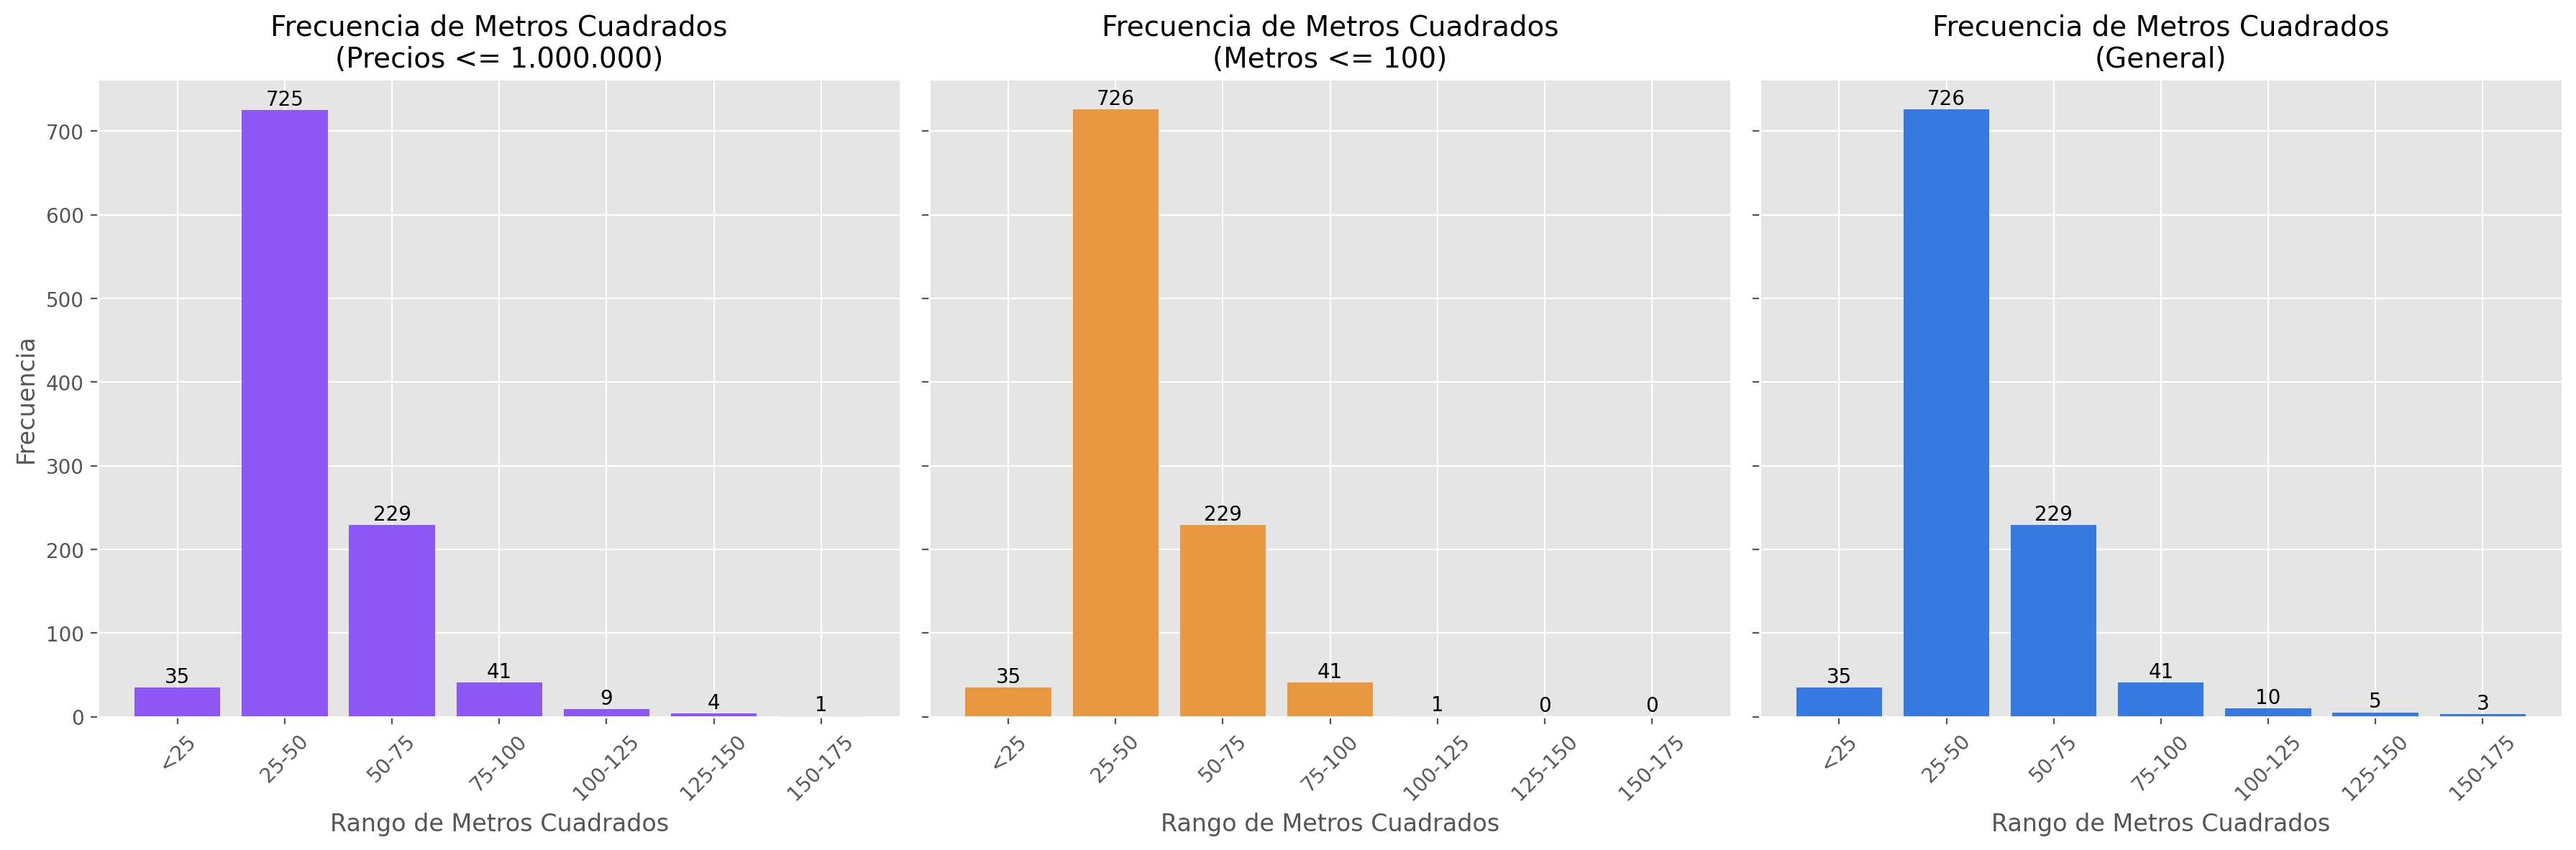

In [36]:
# Definir los rangos y etiquetas para los metros cuadrados (incrementos de 25)
bins_metros = [0, 25, 50, 75, 100, 125, 150, float('inf')]
labels_metros = [
    '<25', '25-50', '50-75', '75-100', '100-125', '125-150', '150-175'
]

# Clasificar y contar frecuencias para cada caso
conteo_precios = pd.cut(
    data_filtrada_precios['Metros Cuadrados'], 
    bins=bins_metros, 
    labels=labels_metros, 
    right=False
).value_counts().sort_index()

conteo_metros = pd.cut(
    data_filtrada_metros['Metros Cuadrados'], 
    bins=bins_metros, 
    labels=labels_metros, 
    right=False
).value_counts().sort_index()

conteo_general = pd.cut(
    data_procesada['Metros Cuadrados'], 
    bins=bins_metros, 
    labels=labels_metros, 
    right=False
).value_counts().sort_index()

# Crear DataFrames para graficar
datasets = [
    pd.DataFrame({'Rango Metros Cuadrados': conteo_precios.index.astype(str), 'Frecuencia': conteo_precios.values}),
    pd.DataFrame({'Rango Metros Cuadrados': conteo_metros.index.astype(str), 'Frecuencia': conteo_metros.values}),
    pd.DataFrame({'Rango Metros Cuadrados': conteo_general.index.astype(str), 'Frecuencia': conteo_general.values})
]

categories = ['Precios <= 1.000.000', 'Metros <= 100', 'General']
colors = ["#8D57F6", "#E99842", "#3779E3"]

# Crear gráficos de barras
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

for i, dataset in enumerate(datasets):
    bars = axes[i].bar(
        dataset['Rango Metros Cuadrados'], 
        dataset['Frecuencia'], 
        color=colors[i]
    )
    # Agregar valores encima de las barras
    for bar in bars:
        height = bar.get_height()
        axes[i].text(
            bar.get_x() + bar.get_width() / 2,  # Posición X centrada
            height + 1,  # Posición Y ligeramente encima
            f'{int(height)}',  # Valor de la barra
            ha='center', va='bottom', fontsize=10, color="black"
        )
    # Configuración del gráfico
    axes[i].set_title(f"Frecuencia de Metros Cuadrados\n({categories[i]})", fontsize=14)
    axes[i].set_xlabel("Rango de Metros Cuadrados", fontsize=12)
    axes[i].set_xticks(range(len(dataset)))  # Posiciones de las barras
    axes[i].set_xticklabels(dataset['Rango Metros Cuadrados'], rotation=45, fontsize=10)

# Configuración general
axes[0].set_ylabel("Frecuencia", fontsize=12)
plt.tight_layout()
plt.show()

/var/folders/tg/h6x1ph8j2dbgdffzjyvt5s8r0000gn/T/ipykernel_60151/2351205827.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['Dormitorios_Num'] = pd.to_numeric(dataset['Dormitorios'], errors='coerce')
/var/folders/tg/h6x1ph8j2dbgdffzjyvt5s8r0000gn/T/ipykernel_60151/2351205827.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['Dormitorios_Num'] = pd.to_numeric(dataset['Dormitorios'], errors='coerce')
/var/folders/tg/h6x1ph8j2dbgdffzjyvt5s8r0000gn/T/ipykernel_60151/2351205827.py:6: Settin

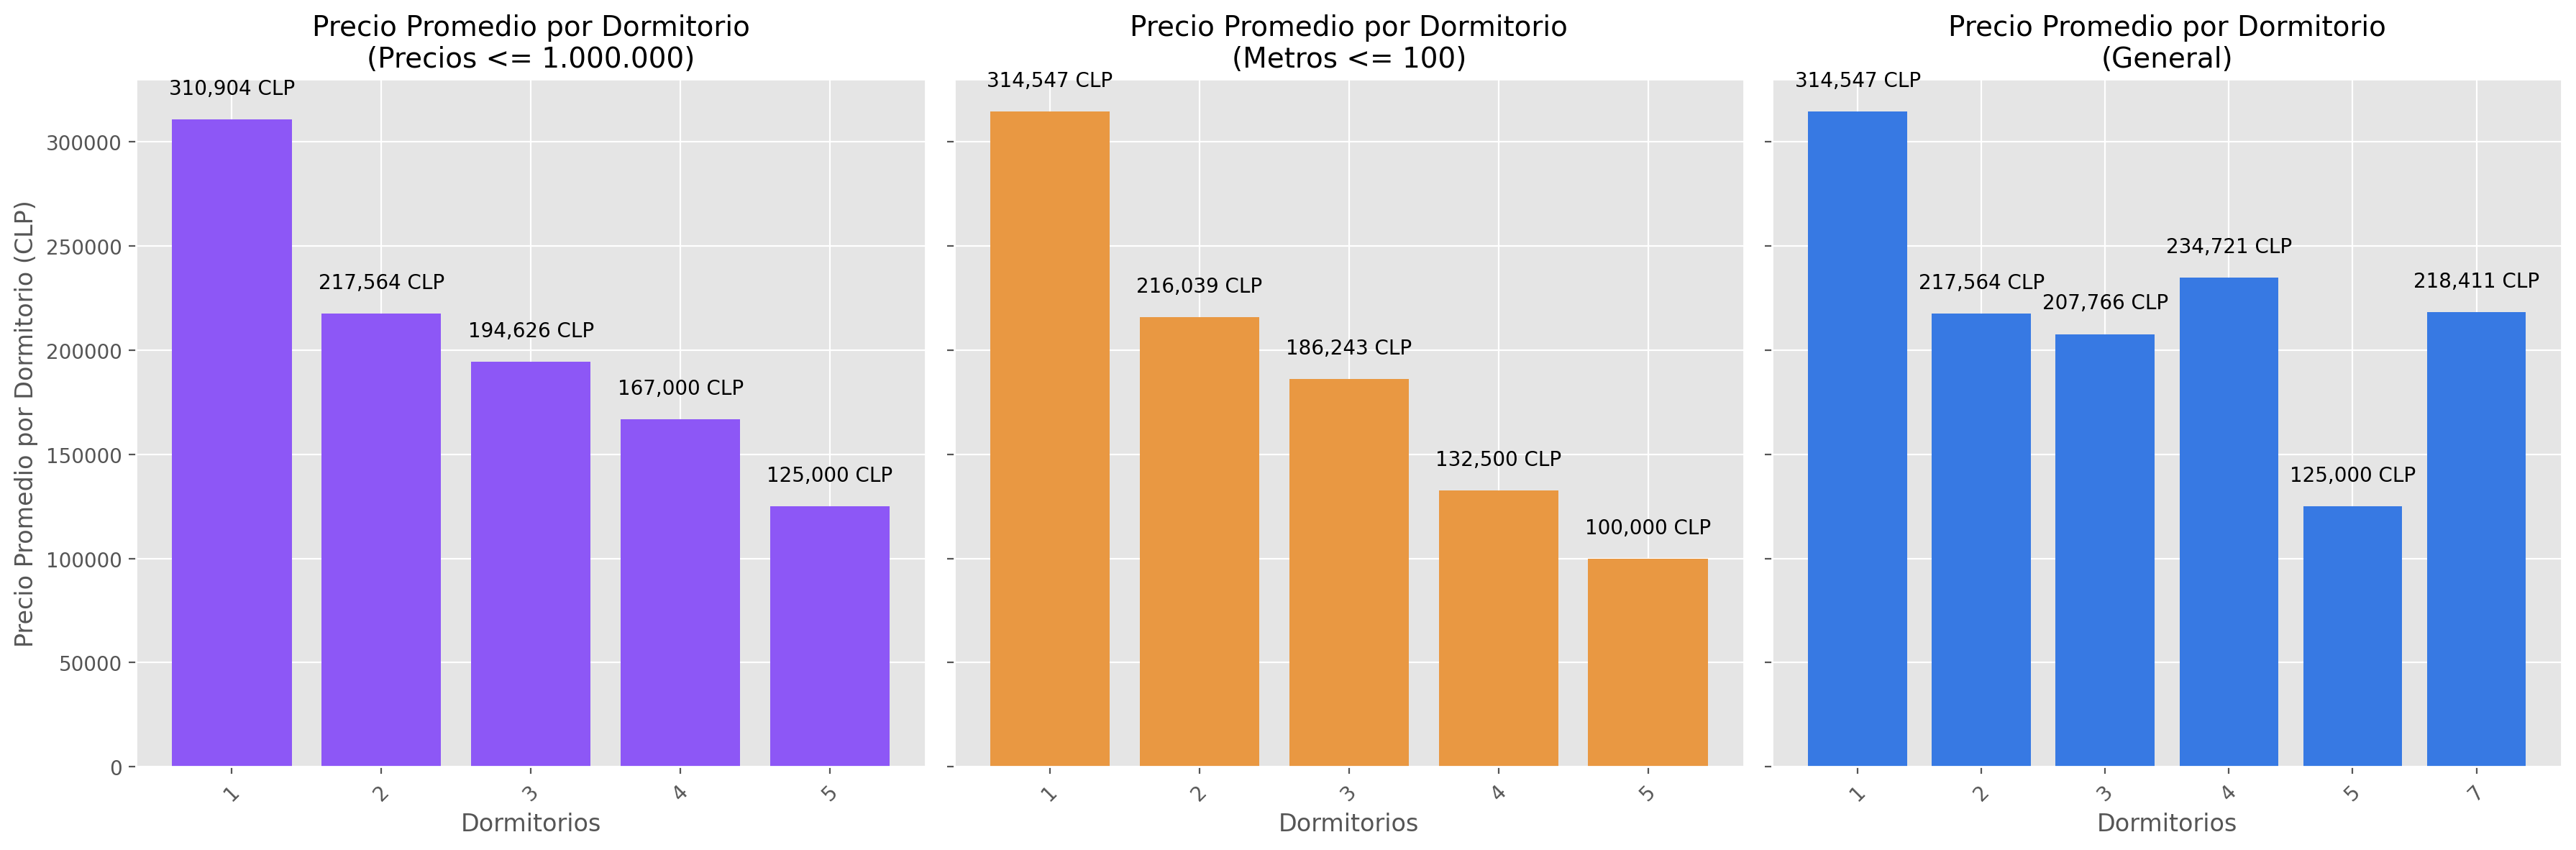

In [37]:
# Función para calcular el precio promedio por dormitorio por categoría
def precio_promedio_por_dormitorio(dataset):
    # Filtrar valores no numéricos como "estudio"
    dataset = dataset[~dataset['Dormitorios'].str.contains("estudio", case=False, na=False)]
    # Convertir "Dormitorios" a numérico (ignorar posibles errores de conversión)
    dataset['Dormitorios_Num'] = pd.to_numeric(dataset['Dormitorios'], errors='coerce')
    # Eliminar filas donde "Dormitorios_Num" sea NaN (por valores no numéricos)
    dataset = dataset.dropna(subset=['Dormitorios_Num'])
    # Filtrar precios atípicos (opcional)
    dataset = dataset[(dataset['Precio_Numerico'] > 0) & (dataset['Precio_Numerico'] < 500000000)]  # Rango de precios razonable
    # Agrupar por cantidad de dormitorios y calcular el precio promedio por dormitorio
    resultado = dataset.groupby('Dormitorios_Num').apply(
        lambda x: (x['Precio_Numerico'] / x['Dormitorios_Num']).mean()
    ).reset_index()
    resultado.columns = ['Dormitorios', 'Precio por Dormitorio']
    return resultado

# Calcular para cada subconjunto
precio_por_dormitorio_precios = precio_promedio_por_dormitorio(data_filtrada_precios)
precio_por_dormitorio_metros = precio_promedio_por_dormitorio(data_filtrada_metros)
precio_por_dormitorio_general = precio_promedio_por_dormitorio(data_procesada)

# Crear listas de datasets y categorías
datasets = [precio_por_dormitorio_precios, precio_por_dormitorio_metros, precio_por_dormitorio_general]
categories = ['Precios <= 1.000.000', 'Metros <= 100', 'General']
colors = ["#8D57F6", "#E99842", "#3779E3"]

# Graficar
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

for i, dataset in enumerate(datasets):
    # Ordenar los datos por precio promedio por dormitorio
    dataset = dataset.sort_values(by='Dormitorios')
    
    # Crear posiciones numéricas para las barras
    x_pos = range(len(dataset))
    
    # Crear barras
    bars = axes[i].bar(x_pos, dataset['Precio por Dormitorio'], color=colors[i])
    
    # Agregar valores encima de las barras
    for bar, value in zip(bars, dataset['Precio por Dormitorio']):
        height = bar.get_height()
        axes[i].text(
            bar.get_x() + bar.get_width() / 2,  # Posición X centrada
            height + 10000,  # Posición Y ligeramente encima
            f'{int(value):,} CLP',  # Valor de la barra (formato de miles)
            ha='center', va='bottom', fontsize=10, color="black"
        )
    
    # Configuración del gráfico
    axes[i].set_title(f"Precio Promedio por Dormitorio\n({categories[i]})", fontsize=14)
    axes[i].set_xlabel("Dormitorios", fontsize=12)
    axes[i].set_xticks(x_pos)  # Posiciones de las barras
    axes[i].set_xticklabels(dataset['Dormitorios'].astype(int), rotation=45, fontsize=10)

# Configuración general
axes[0].set_ylabel("Precio Promedio por Dormitorio (CLP)", fontsize=12)
plt.tight_layout()
plt.show()